In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
import fiona
import rasterio
import regionmask
warnings.filterwarnings('ignore')
import seaborn as sns
import geopandas as gpd


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
class BasinTree(object):
    def __init__(self, country, children=[], variable=[], ensemble=[]):
        self.children: List[Tree] = children
        self.country: String = country
        self.variable: Float = variable # this will be cleared each time
        self.ensemble: List = ensemble # this will be appended to
            
    def __repr__(self):
        return f'Tree of {self.country} with {len(self.children)} children'
    
    def is_headwaters(self):
        return len(self.children) == 0
            
    def __iter__(self):
        yield self
        for child in self.children:
            for node in child:
                yield node
                
    def is_parent(self, other):
        '''This checks "other" and returns whether it
        is a parent of the "self"'''
        all_parents = [o for o in other]
        return self in all_parents
    
    def make_comparison(self, value, metric):
        ''' Hacky way of doing this - actually will want
        to do it as an ensemble measure '''
        if metric=='mean':
            if value > 0.1:
                return 'Increase'
            elif value < -0.1:
                return 'Decrease'
            elif (value < 0.1) & (value > -0.1):
                return 'No Change'
        elif metric=='h_range':
            if value > 0.05:
                return 'Increase'
            elif value < -0.05:
                return 'Decrease'
            elif (value < 0.05) & (value > -0.05):
                return 'No Change'            

    def compare_all_children(self, metric):
        '''Makes comparison of all children (including self)
        to see how children/parent relationships differ
        
        Returns: a matrix of child (columns; upstream) and 
        parents (rows; downstream) changes; add a tick for each
        combination of children and parents; compare the variable
        fed in when initalizing the tree
        '''
        # initalize the dataframe which will hold the analyses
        comparison_df = pd.DataFrame(np.zeros((3,3)), 
                                     columns = ['Decrease', 'No Change', 'Increase'],
                                     index = ['Increase', 'No Change', 'Decrease'])
        for upstream in self:
            for downstream in self:
                if upstream.is_parent(downstream) and upstream is not downstream:
                    try:
                        change_upstream = self.make_comparison(np.mean(upstream.variable), metric)
                        change_downstream = self.make_comparison(np.mean(downstream.variable), metric)
                            # parents (downstream) are columns; children (upstream) are index

                        comparison_df.at[change_upstream, change_downstream] += 1
                    except:
                        continue
#                         print('{} doesnt exist'.format(upstream.country))
        return comparison_df
    
    def create_upstream_downstream_df(self):
        upstream_downstream_df = pd.DataFrame(columns = ['upstream', 'downstream'])
        for upstream in self:
            for downstream in self:
                if upstream.is_parent(downstream) and upstream is not downstream:
                    try:
                        upstream_downstream_df.at['{}/{}'.format(upstream.country, downstream.country), 'upstream'] = np.median(upstream.ensemble)
                        upstream_downstream_df.at['{}/{}'.format(upstream.country, downstream.country), 'downstream'] = np.median(downstream.ensemble)
                    except:
                        print('{}/{} and {} didnt work'.format(upstream.country, downstream.country))
        return upstream_downstream_df
    
    def find_bad_countries(self, metric):
        '''Finds the countries that are going in the bad direction'''
        bad_countries = []
        for countrytree in self:
            change = self.make_comparison(np.mean(countrytree.variable), metric)
            if ( metric == 'mean') & (change == 'Decrease'):
                bad_countries.append(countrytree.country)
            elif ( metric == 'h_range') & (change == 'Increase'):
                bad_countries.append(countrytree.country)
        return bad_countries
    
#     def most_valid_downstream(self, metric):
#         self.compare_all_children(metric)
                

# Initalize your river basins
#### Need to put the upstream basins in first in order to have self-referential dictionaries

In [3]:
rb = {}

# Mekong

In [4]:

rb['Mekong'] = {'outlet_country': 'Vietnam',
                'China': BasinTree('China', []),
                 'Myanmar (Burma)': BasinTree('Myanmar (Burma)', []),
                 'Thailand': BasinTree('Thailand', [])}
rb['Mekong']['Laos'] = BasinTree('Laos', [rb['Mekong']['China'], 
                                          rb['Mekong']['Myanmar (Burma)']])
rb['Mekong']['Cambodia'] = BasinTree('Cambodia', [rb['Mekong']['Laos'], 
                                                  rb['Mekong']['Thailand']])
rb['Mekong']['Vietnam'] = BasinTree('Vietnam', [rb['Mekong']['Cambodia']])


# Amazon

In [5]:
rb['Amazon'] = {'outlet_country': 'Brazil',
                'Colombia': BasinTree('Columbia', []),
                 'Ecuador': BasinTree('Ecuador', []),
                 'Bolivia': BasinTree('Bolivia', []),
             'Venezuela': BasinTree('Venezuela', []),
                 'Guyana': BasinTree('Guyana', []),
                 'French Guiana': BasinTree('French Guiana', []),}
rb['Amazon']['Peru'] = BasinTree('Peru', [rb['Amazon']['Ecuador']])
rb['Amazon']['Brazil'] = BasinTree('Brazil', [rb['Amazon'][country] for country in ['Colombia',
                                                                                   'Peru',
                                                                                   'Bolivia',
                                                                                   'Venezuela',
                                                                                   'Guyana',
                                                                                   'French Guiana']])

# Nile

In [6]:
rb['Nile'] = {'outlet_country': 'Egypt',
                'Tanzania, United Republic of': BasinTree('Tanzania, United Republic of', []),
                 'Burundi': BasinTree('Burundi', []),
                 'Eritrea': BasinTree('Eritrea', []),
             'Kenya': BasinTree('Kenya', []),
             'Ethiopia': BasinTree('Ethiopia', [])}
rb['Nile']['Rwanda'] = BasinTree('Rwanda', [rb['Nile'][country] for country in ['Burundi']])
rb['Nile']['Uganda'] = BasinTree('Sudan', [rb['Nile'][country] for country in ['Rwanda', 'Kenya', 'Tanzania, United Republic of']])
rb['Nile']['Sudan'] = BasinTree('Sudan', [rb['Nile'][country] for country in ['Ethiopia', 'Uganda', 'Eritrea']])

rb['Nile']['Egypt'] = BasinTree('Egypt', [rb['Nile'][country] for country in ['Sudan']])

# Columbia

In [7]:
rb['Columbia'] = {'outlet_country': 'United States',
                'Canada': BasinTree('Canada', [])}
rb['Columbia']['United States'] = BasinTree('United States', [rb['Columbia'][country] for country in ['Canada']])

# Congo

In [8]:
rb['Zaire'] = {'outlet_country': 'Zaire',
                'Cameroon': BasinTree('Cameroon', []),
              'Congo': BasinTree('Congo', []),
              'Angola': BasinTree('Angola', []),
              'Central African Republic': BasinTree('Central African Republic', []),
              'Zambia': BasinTree('Zambia', []),
              'Tanzania, United Republic of': BasinTree('Tanzania, United Republic of', [])}
rb['Zaire']['Burundi'] = BasinTree('Burundi', [rb['Zaire'][country] for country in ['Tanzania, United Republic of']])
rb['Zaire']['Rwanda'] = BasinTree('Rwanda', [rb['Zaire'][country] for country in ['Burundi']])
rb['Zaire']['Zaire'] = BasinTree('Zaire', [rb['Zaire'][country] for country in ['Rwanda', 'Angola', 'Zambia',
                                                                               'Congo', 'Central African Republic']])

# Ca - too small

# Essequibo

In [9]:
rb['Essequibo'] = {'outlet_country': 'Guyana',
                'Venezuela': BasinTree('Venezuela', []),}
rb['Essequibo']['Guyana'] = BasinTree('Guyana', [rb['Essequibo'][country] 
                                            for country in ['Venezuela']])


# Irrawaddy

In [10]:
rb['Irrawaddy'] = {'outlet_country': 'Myanmar (Burma)',
                'India': BasinTree('India', []),
                  'China': BasinTree('China', [])}
rb['Irrawaddy']['Myanmar (Burma)'] = BasinTree('Myanmar (Burma)', [rb['Irrawaddy'][country] 
                                            for country in ['India', 'China']])


# Jubba-Shebelle

In [11]:
rb['Jubba-Shebelle'] = {'outlet_country': 'Somalia',
                'Ethiopia': BasinTree('Ethiopia', []),
                  'Kenya': BasinTree('Kenya', [])}
rb['Jubba-Shebelle']['Somalia'] = BasinTree('Somalia', [rb['Jubba-Shebelle'][country] 
                                            for country in ['Ethiopia', 'Kenya']])


# Lake Chad

In [12]:
# Don't know - weird situation with shared waterfront on endorrheic basin lake

# Lake Turkana

In [13]:
rb['Lake Turkana'] = {'outlet_country': 'Kenya',
                'Ethiopia': BasinTree('Ethiopia', [])}
rb['Lake Turkana']['Kenya'] = BasinTree('Kenya', [rb['Lake Turkana'][country] 
                                            for country in ['Ethiopia']])


# Ma - vietnam

# Maritsa

In [14]:
rb['Maritsa'] = {'outlet_country': 'Turkey',
                'Bulgaria': BasinTree('Bulgaria', [])}
rb['Maritsa']['Turkey'] = BasinTree('Turkey', [rb['Maritsa'][country] 
                                            for country in ['Bulgaria']])


# Mono - too small

# Ob

In [15]:
rb['Ob'] = {'outlet_country': 'Russia',
           'Mongolia': BasinTree('Mongolia', [])}
rb['Ob']['China'] = BasinTree('China', [rb['Ob'][country] 
                                            for country in ['Mongolia']])
rb['Ob']['Kazakhstan'] = BasinTree('Kazakhstan', [rb['Ob'][country] 
                                            for country in ['China']])
rb['Ob']['Russia'] = BasinTree('Russia', [rb['Ob'][country] 
                                            for country in ['Kazakhstan']])

# Ogooue

In [16]:
rb['Ogooue'] = {'outlet_country': 'Gabon',
           'Congo': BasinTree('Congo', []),
           'Cameroon': BasinTree('Cameroon', []),
           'Equatorial Guinea': BasinTree('Equatorial Guinea', [])}
rb['Ogooue']['Gabon'] = BasinTree('Gabon', [rb['Ogooue'][country] 
                                            for country in ['Equatorial Guinea',
                                                           'Congo',
                                                           'Cameroon']])

# Orinoco

In [17]:
rb['Orinoco'] = {'outlet_country': 'Venezuela',
           'Brazil': BasinTree('Brazil', []),
           'Colombia': BasinTree('Colombia', [])}
rb['Orinoco']['Venezuela'] = BasinTree('Venezuela', [rb['Orinoco'][country] 
                                            for country in ['Brazil', 'Colombia']])

# Song Hong

In [18]:
rb['Song Hong'] = {'outlet_country': 'Vietnam',
           'China': BasinTree('China', [])}
rb['Song Hong']['Vietnam'] = BasinTree('Vietnam', [rb['Song Hong'][country] 
                                            for country in ['China']])

# Saigon

In [19]:
rb['Saigon'] = {'outlet_country': 'Vietnam',
           'Cambodia': BasinTree('Cambodia', [])}
rb['Saigon']['Vietnam'] = BasinTree('Vietnam', [rb['Saigon'][country] 
                                            for country in ['Cambodia']])

# Salween

In [20]:
rb['Salween'] = {'outlet_country': 'Myanmar (Burma)',
           'China': BasinTree('China', []),
                'Thailand': BasinTree('Thailand', [])}
rb['Salween']['Myanmar (Burma)'] = BasinTree('Myanmar (Burma)', 
                                             [rb['Salween'][country] 
                                            for country in ['China', 'Thailand']])

# Sanaga - upstream countries too little contributing area

# San Juan

In [21]:
rb['San Juan'] = {'outlet_country': 'Costa Rica',
           'Nicaragua': BasinTree('Nicaragua', [])}
rb['San Juan']['Costa Rica'] = BasinTree('Costa Rica', 
                                             [rb['San Juan'][country] 
                                            for country in ['Nicaragua']])

# Tarim (Yarkand)

In [22]:
rb['Tarim (Yarkand)'] = {'outlet_country': 'China',
           'Kyrgyzstan': BasinTree('Kyrgyzstan', []),
            'Tajikistan': BasinTree('Tajikistan', []),
            'Pakistan': BasinTree('Pakistan', [])}
rb['Tarim (Yarkand)']['China'] = BasinTree('China', 
                                             [rb['Tarim (Yarkand)'][country] 
                                            for country in ['Kyrgyzstan',
                                                           'Tajikistan',
                                                           'Pakistan']])

# Vardar

In [23]:
rb['Vardar'] = {'outlet_country': 'Greece',
           'Serbia': BasinTree('Serbia', [])}
rb['Vardar']['Macedonia'] = BasinTree('Macedonia', 
                                             [rb['Vardar'][country] 
                                            for country in ['Serbia']])
rb['Vardar']['Greece'] = BasinTree('Greece', 
                                             [rb['Vardar'][country] 
                                            for country in ['Macedonia']])

# Ganges-Brahmabutra

In [24]:
rb['Ganges-Brahmaputra'] = {'outlet_country': 'Bangladesh',
           'China': BasinTree('China', []),
            'Bhutan': BasinTree('Bhutan', []),
            'Nepal': BasinTree('Nepal', [])}
rb['Ganges-Brahmaputra']['India'] = BasinTree('India', 
                                             [rb['Ganges-Brahmaputra'][country] 
                                            for country in ['Nepal', 'Bhutan']])
rb['Ganges-Brahmaputra']['Bangladesh'] = BasinTree('Bangladesh', 
                                             [rb['Ganges-Brahmaputra'][country] 
                                            for country in ['India']])

# Niger

In [25]:
rb['Niger'] = {'outlet_country': 'Nigeria',
           'Sierra Leone': BasinTree('Sierra Leone', []),
               'Ivory Coast': BasinTree('Ivory Coast', []),
              'Benin': BasinTree('Benin', []),
              'Burkina Faso': BasinTree('Burkina Faso', []),
              'Cameroon': BasinTree('Cameroon', []),
              'Algeria': BasinTree('Algeria', [])}
rb['Niger']['Guinea'] = BasinTree('Guinea', 
                                [rb['Niger'][country] 
                                for country in ['Sierra Leone']])
rb['Niger']['Mali'] = BasinTree('Mali', 
                                [rb['Niger'][country] 
                                for country in ['Guinea', 'Ivory Coast']])
rb['Niger']['Niger'] = BasinTree('Niger', 
                                [rb['Niger'][country] 
                                for country in ['Mali', 'Burkina Faso', 'Algeria']])
rb['Niger']['Nigeria'] = BasinTree('Nigeria', 
                                [rb['Niger'][country] 
                                for country in ['Niger', 'Benin', 'Cameroon']])

# Senegal

In [26]:
rb['Senegal'] = {'outlet_country': 'Senegal',
           'Guinea': BasinTree('Guinea', []),
            'Nepal': BasinTree('Nepal', [])}
rb['Senegal']['Mali'] = BasinTree('Mali', 
                                    [rb['Senegal'][country] 
                                    for country in ['Guinea']])
rb['Senegal']['Mauritania'] = BasinTree('Mauritania', 
                                             [rb['Senegal'][country] 
                                            for country in ['Mali']])
rb['Senegal']['Senegal'] = BasinTree('Senegal', 
                                             [rb['Senegal'][country] 
                                            for country in ['Mauritania']])

# Indus

In [27]:
rb['Indus'] = {'outlet_country': 'Pakistan',
           'China': BasinTree('China', []),
            'Afghanistan': BasinTree('Afghanistan', [])}
rb['Indus']['India'] = BasinTree('India', 
                                    [rb['Indus'][country] 
                                    for country in ['China']])
rb['Indus']['Pakistan'] = BasinTree('Pakistan', 
                                             [rb['Indus'][country] 
                                            for country in ['India', 'Afghanistan']])

# Tigris-Euphrates

In [28]:
rb['Tigris-Euphrates'] = {'outlet_country': 'Iraq',
           'Turkey': BasinTree('Turkey', []),
            'Iran': BasinTree('Iran', [])}
rb['Tigris-Euphrates']['Syria'] = BasinTree('Syria', 
                                    [rb['Tigris-Euphrates'][country] 
                                    for country in ['Turkey']])
rb['Tigris-Euphrates']['Iraq'] = BasinTree('Iraq', 
                                             [rb['Tigris-Euphrates'][country] 
                                            for country in ['Syria', 
                                                            'Iran']])

# Uruguay

In [29]:
rb['Uruguay'] = {'outlet_country': 'Uruguay',
            'Brazil': BasinTree('Brazil', [])}
rb['Uruguay']['Argentina'] = BasinTree('Argentina', 
                                             [rb['Uruguay'][country] 
                                            for country in ['Brazil']])
rb['Uruguay']['Uruguay'] = BasinTree('Uruguay', 
                                             [rb['Uruguay'][country] 
                                            for country in ['Argentina']])

# Parana

In [30]:
rb['Parana'] = {'outlet_country': 'Argentina',
            'Brazil': BasinTree('Brazil', []),
               'Bolivia': BasinTree('Bolivia', [])}
rb['Parana']['Paraguay'] = BasinTree('Paraguay', 
                                             [rb['Parana'][country] 
                                            for country in ['Brazil', 'Bolivia']])
rb['Parana']['Argentina'] = BasinTree('Argentina', 
                                             [rb['Parana'][country] 
                                            for country in ['Paraguay']])

# Zambezi

In [31]:
rb['Zambezi'] = {'outlet_country': 'Mozambique',
            'Tanzania, United Republic of': BasinTree('Tanzania, United Republic of', []),
                'Angola': BasinTree('Angola', []),
                'Botswana': BasinTree('Botswana', []),
                'Zimbabwe': BasinTree('Zimbabwe', []),
                'Namibia': BasinTree('Namibia', [])}
rb['Zambezi']['Malawi'] = BasinTree('Malawi', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Tanzania, United Republic of']])
rb['Zambezi']['Zambia'] = BasinTree('Zambia', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Angola', 'Botswana', 'Namibia']])
rb['Zambezi']['Mozambique'] = BasinTree('Mozambique', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Zambia', 'Zimbabwe', 'Malawi']])


# Danube

In [32]:
rb['Danube'] = {'outlet_country': 'Ukraine',
            'Germany': BasinTree('Germany', []),
                'Czech Republic': BasinTree('Czech Republic', []),
                'Slovakia': BasinTree('Slovakia', []),
                'Slovenia': BasinTree('Slovenia', []),
                'Montenegro': BasinTree('Montenegro', []),
                'Bosnia and Herzegovina': BasinTree('Bosnia and Herzegovina', []),
               'Bulgaria': BasinTree('Bulgaria', []), }
rb['Danube']['Austria'] = BasinTree('Austria', [rb['Danube'][country] 
                                            for country in ['Czech Republic', 
                                                            'Germany']])
rb['Danube']['Hungary'] = BasinTree('Hungary', [rb['Danube'][country] 
                                            for country in ['Austria', 
                                                            'Slovakia']])
rb['Danube']['Croatia'] = BasinTree('Croatia', 
                                             [rb['Danube'][country] 
                                            for country in ['Slovenia']])
rb['Danube']['Serbia'] = BasinTree('Serbia', [rb['Danube'][country] 
                                            for country in ['Bosnia and Herzegovina',
                                                           'Montenegro',
                                                           'Hungary']])
rb['Danube']['Romania'] = BasinTree('Romania', [rb['Danube'][country] 
                                            for country in ['Bulgaria',
                                                            'Serbia']])
rb['Danube']['Moldova'] = BasinTree('Moldova', [rb['Danube'][country] 
                                            for country in ['Romania']])
rb['Danube']['Ukraine'] = BasinTree('Ukraine', [rb['Danube'][country] 
                                            for country in ['Moldova']])

# Colorado

In [33]:
rb['Colorado'] = {'outlet_country': 'Mexico',
            'United States': BasinTree('United States', [])}
rb['Colorado']['Mexico'] = BasinTree('Mexico', 
                                             [rb['Colorado'][country] 
                                            for country in ['United States']])

# Rhine

In [34]:
rb['Rhine'] = {'outlet_country': 'Netherlands',
                'Austria': BasinTree('Austria', []),
                 'Liechtenstein': BasinTree('Liechtenstein', []),
                 'France': BasinTree('France', []),
                 'Belgium': BasinTree('Belgium', []),
                 'Italy': BasinTree('Italy', []),}
rb['Rhine']['Luxembourg'] = BasinTree('Luxembourg', [rb['Rhine'][country] for country in ['Belgium']])
rb['Rhine']['Switzerland'] = BasinTree('Switzerland', [rb['Rhine'][country] for country in ['Austria',
                                                                                           'Liechtenstein']])

rb['Rhine']['Germany'] = BasinTree('Germany', [rb['Rhine'][country] for country in ['France',
                                                                                    'Luxembourg',
                                                                                   'Switzerland']])

rb['Rhine']['Netherlands'] = BasinTree('Netherlands', [rb['Rhine']['Germany']])

# Load in your shapefiles with changes

In [35]:
subbasins = {}
setups = ['CSIRO-ARCCSS.ACCESS-CM2',
             'MIROC.MIROC-ES2L',
             'CCCma.CanESM5-CanOE',
             'INM.INM-CM5-0',
              'CAMS.CAMS-CSM1-0',
              'EC-Earth-Consortium.EC-Earth3-Veg',
              'INM.INM-CM4-8',
              'CSIRO-ARCCSS.ACCESS-CM2',
#               'CCCma.CanESM5',
             'UA.MCM-UA-1-0',
             'NIMS-KMA.KACE-1-0-G',
             'NOAA-GFDL.GFDL-CM4',
             'CSIRO.ACCESS-ESM1-5',
             'NCAR.CESM2',
             'MRI.MRI-ESM2-0',
         'FIO-QLNM.FIO-ESM-2-0',
         'MIROC.MIROC6',
         'MPI-M.MPI-ESM1-2-LR',
         'BCC.BCC-CSM2-MR',
         'CNRM-CERFACS.CNRM-ESM2-1',
         'MOHC.UKESM1-0-LL',
         'NCAR.CESM2-WACCM',
         'CNRM-CERFACS.CNRM-CM6-1',
         'IPSL.IPSL-CM6A-LR']
for setup in setups:
    subbasins[setup] = gpd.read_file('{}_ssp585_polygon_changes_all_basins.shp'.format(setup))
    subbasins[setup] = subbasins[setup][~np.isnan(subbasins[setup]['mean'])]

In [36]:
# take your initalized river basin and fill it with each of the 
# changes from the subbasin geopandas dataframe
river_basins = rb.keys()#['Amazon', 'Mekong', 'Rhine', 'Zaire', 'Nile', 'Columbia']
drop_tiny_upstream_countries=True
metric_shorthand_dict = {'hydrologic range': 'h_range',
                        'mean': 'mean'}
river_basin_comparison_dict = {}
for metric in ['hydrologic range', 'mean']:
    metric_shorthand = metric_shorthand_dict[metric]
    river_basin_comparison_dict[metric] = {}
    for river_basin in list(rb.keys()):
        river_basin_comparison_dict[metric][river_basin] = {}
        river_basin_comparison_dict[metric][river_basin]['Full Ensemble'] = pd.DataFrame(np.zeros((3,3)), 
                                         columns = ['Decrease', 'No Change', 'Increase'],
                                         index = ['Increase', 'No Change', 'Decrease'])
        river_basin_comparison_dict[metric][river_basin]['bad countries'] = []
        # clear the ensemble records for all of the GCM setups
        for country in rb[river_basin].keys():
            if country=='outlet_country':
                continue
            rb[river_basin][country].ensemble = []
        for setup in setups:
            sample_gpdfile =  gpd.read_file('{}_polygon_historical.shp'.format(setup))
            i=0
            outlet_country = rb[river_basin]['outlet_country']
            for country in rb[river_basin].keys():
                if country=='outlet_country':
                    continue
                if drop_tiny_upstream_countries:
                    try:
                        num_cells = sample_gpdfile[sample_gpdfile['SUBBASIN_N']=='{}_{}'.format(river_basin, country)]['NumCells'].values[0]
                    except:
                        print('{} didnt work'.format(country))
                    if (num_cells == 0.0) and (country != rb[river_basin]['outlet_country']):
                        print('no cells for {} {} {}'.format(setup, river_basin, country))
                        continue
                try:
                    rb[river_basin][country].variable = np.nan # always clear the variable before each new country/setup
                    rb[river_basin][country].variable = subbasins[setup][(subbasins[setup]['NAME']==river_basin) & 
                                        (subbasins[setup]['CNTRY_NAME']==country)][metric_shorthand].values[0]
                    rb[river_basin][country].ensemble.append(rb[river_basin][country].variable)
                except:
                    continue
            river_basin_comparison_dict[metric][river_basin]['upstream/downstream df'] = rb[river_basin][outlet_country].create_upstream_downstream_df()

    #         print('for gcm setup {} and river basin {} there were {} valid countries'.format(setup, river_basin, i))
            river_basin_comparison_dict[metric][river_basin]['Full Ensemble'] += rb[river_basin][outlet_country].compare_all_children(metric_shorthand)
            river_basin_comparison_dict[metric][river_basin]['bad countries'].append(rb[river_basin][outlet_country].find_bad_countries(metric_shorthand)) 
        

no cells for CSIRO-ARCCSS.ACCESS-CM2 Mekong Myanmar (Burma)
no cells for MIROC.MIROC-ES2L Mekong Myanmar (Burma)
no cells for CCCma.CanESM5-CanOE Mekong Myanmar (Burma)
no cells for INM.INM-CM5-0 Mekong Myanmar (Burma)
no cells for INM.INM-CM4-8 Mekong Myanmar (Burma)
no cells for CSIRO-ARCCSS.ACCESS-CM2 Mekong Myanmar (Burma)
no cells for UA.MCM-UA-1-0 Mekong Myanmar (Burma)
no cells for NIMS-KMA.KACE-1-0-G Mekong Myanmar (Burma)
no cells for MPI-M.MPI-ESM1-2-LR Mekong Myanmar (Burma)
no cells for MOHC.UKESM1-0-LL Mekong Myanmar (Burma)
no cells for CSIRO-ARCCSS.ACCESS-CM2 Amazon French Guiana
no cells for MIROC.MIROC-ES2L Amazon Guyana
no cells for MIROC.MIROC-ES2L Amazon French Guiana
no cells for CCCma.CanESM5-CanOE Amazon Guyana
no cells for CCCma.CanESM5-CanOE Amazon French Guiana
no cells for INM.INM-CM5-0 Amazon French Guiana
no cells for CAMS.CAMS-CSM1-0 Amazon French Guiana
no cells for EC-Earth-Consortium.EC-Earth3-Veg Amazon French Guiana
no cells for INM.INM-CM4-8 Amazon F

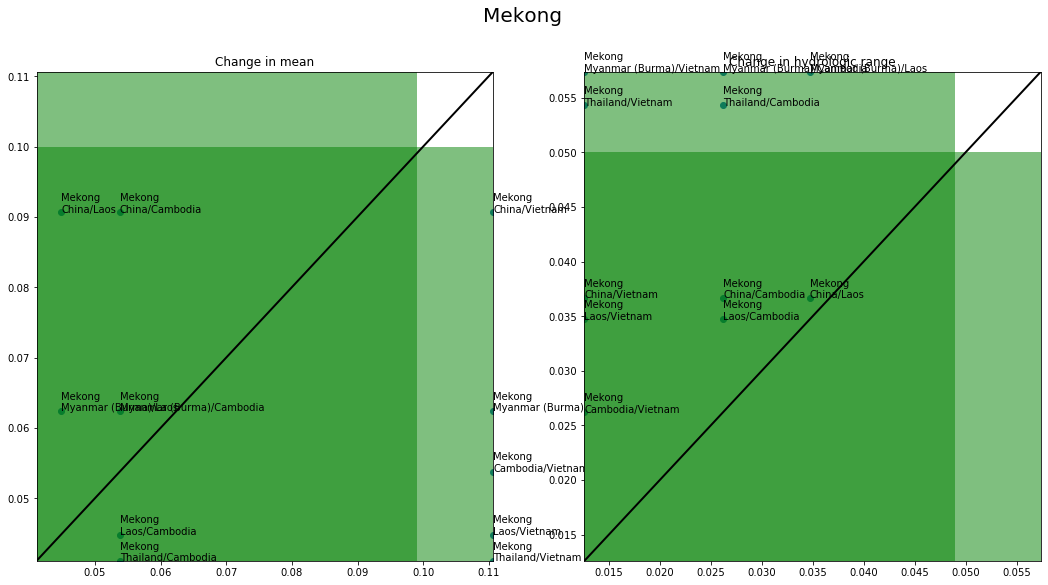

ValueError: Image size of 54952x95637 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x648 with 2 Axes>

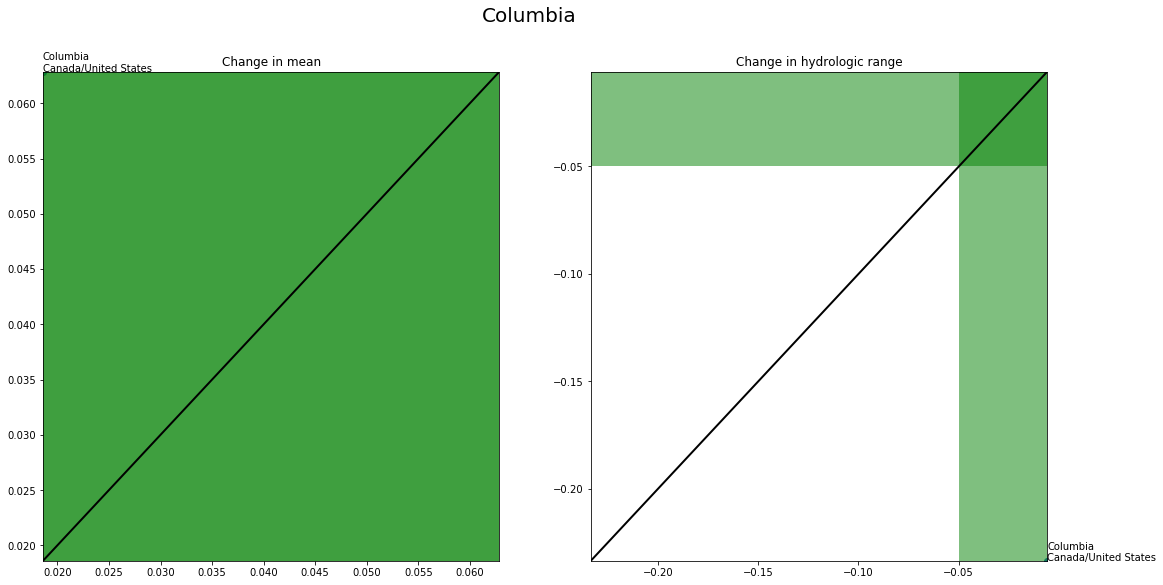

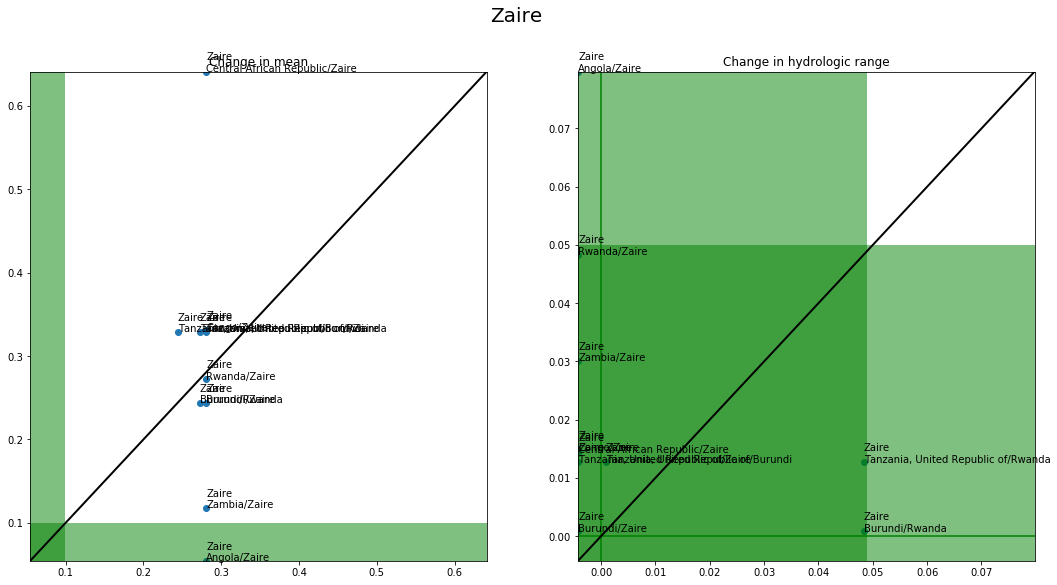

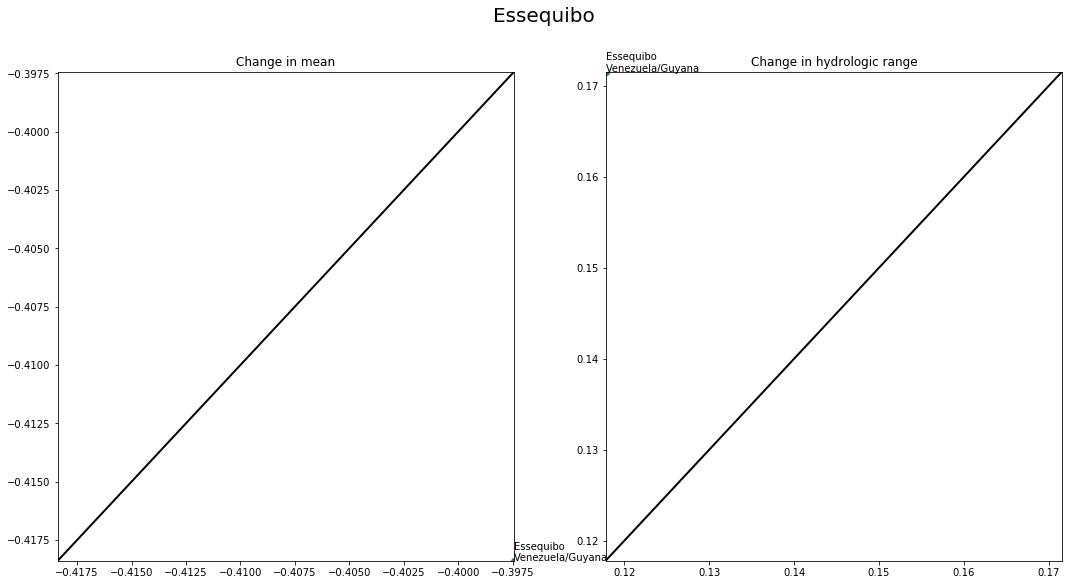

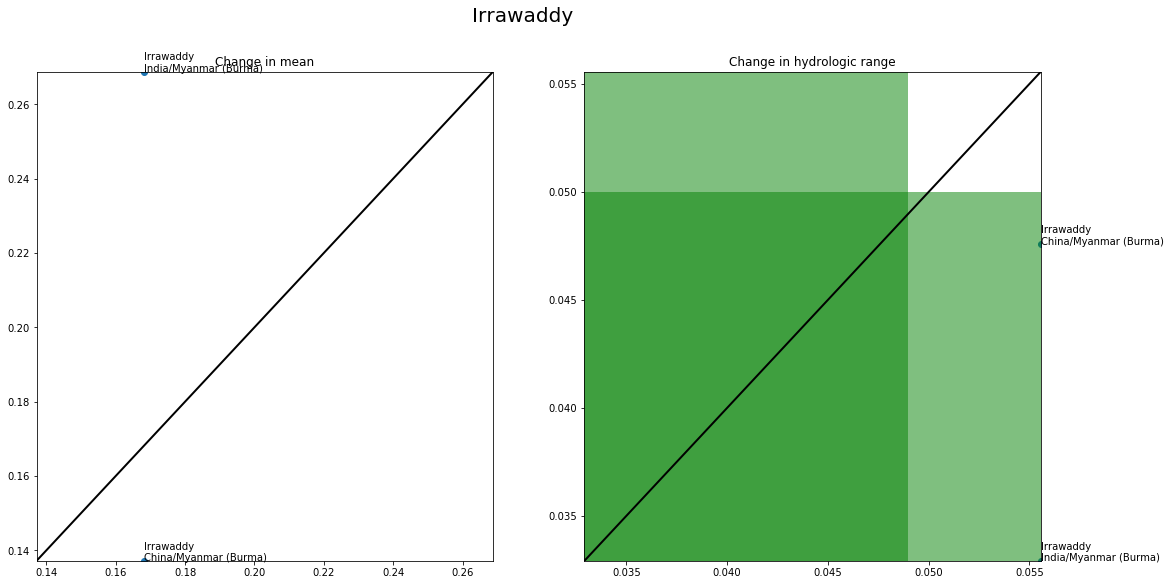

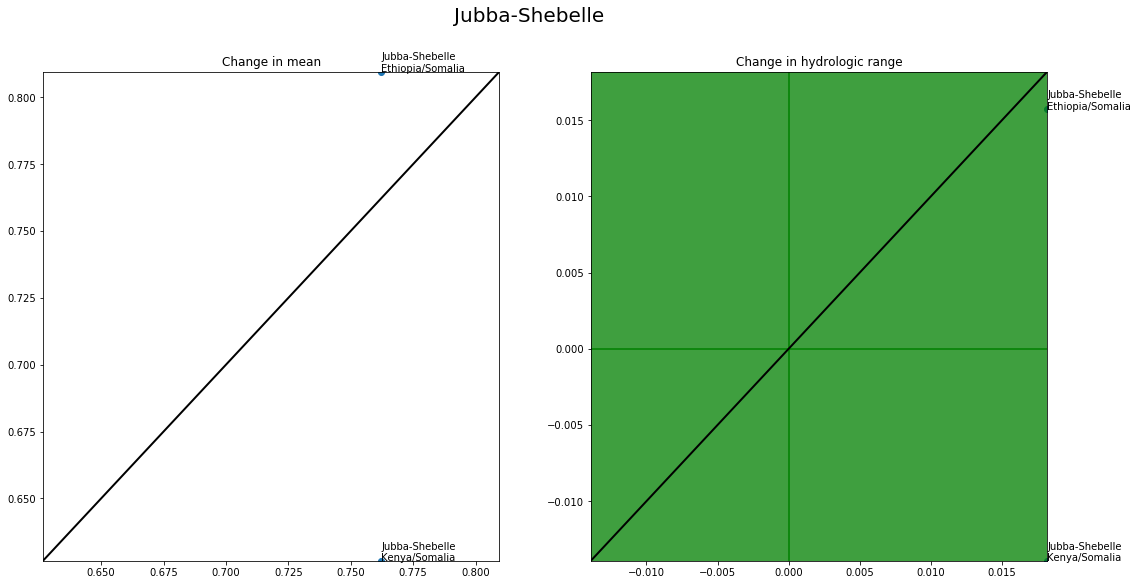

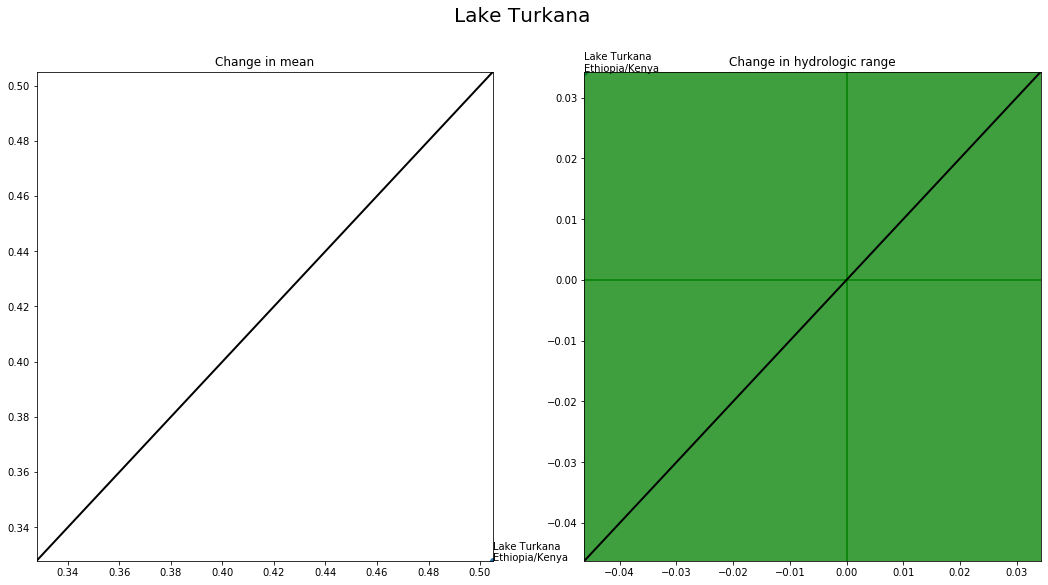

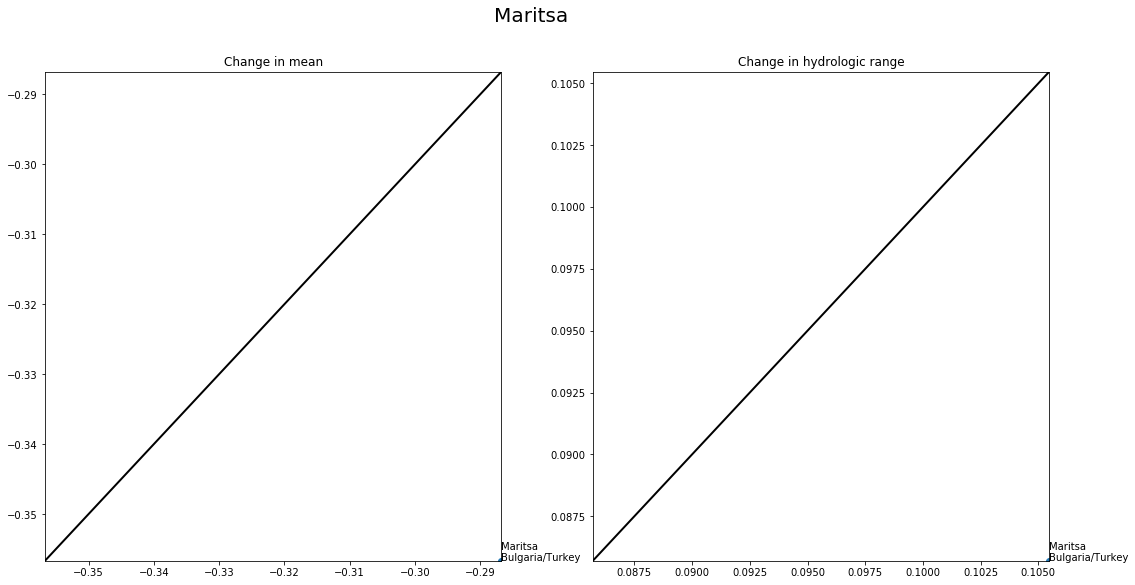

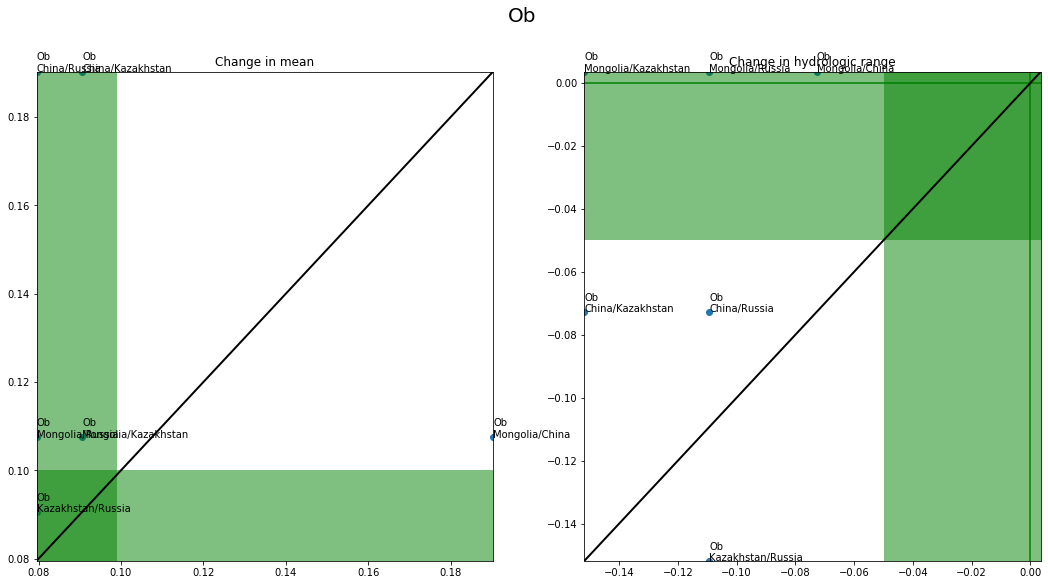

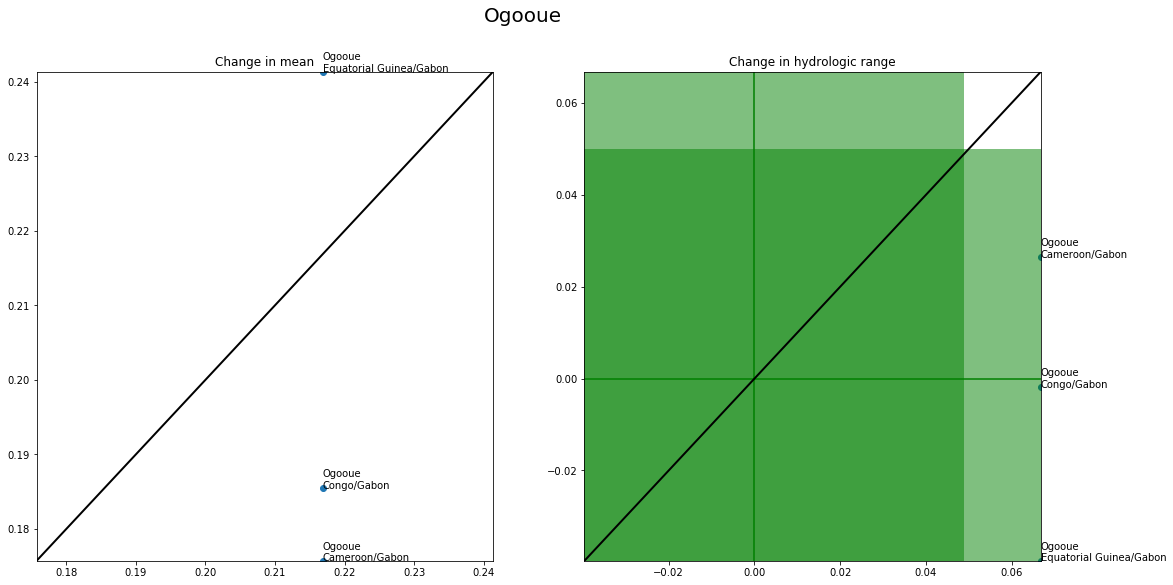

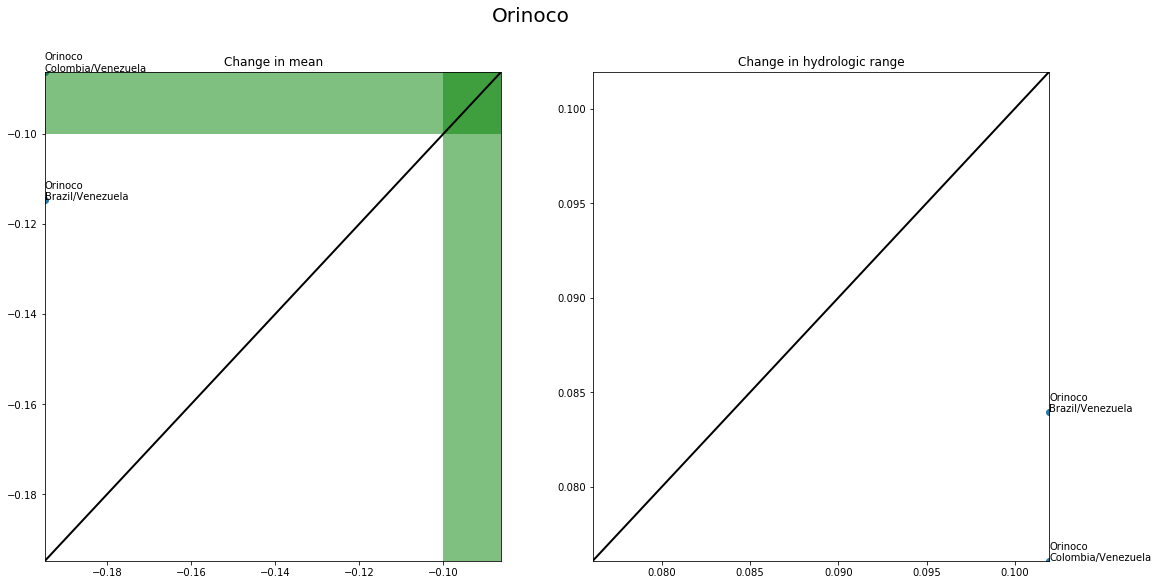

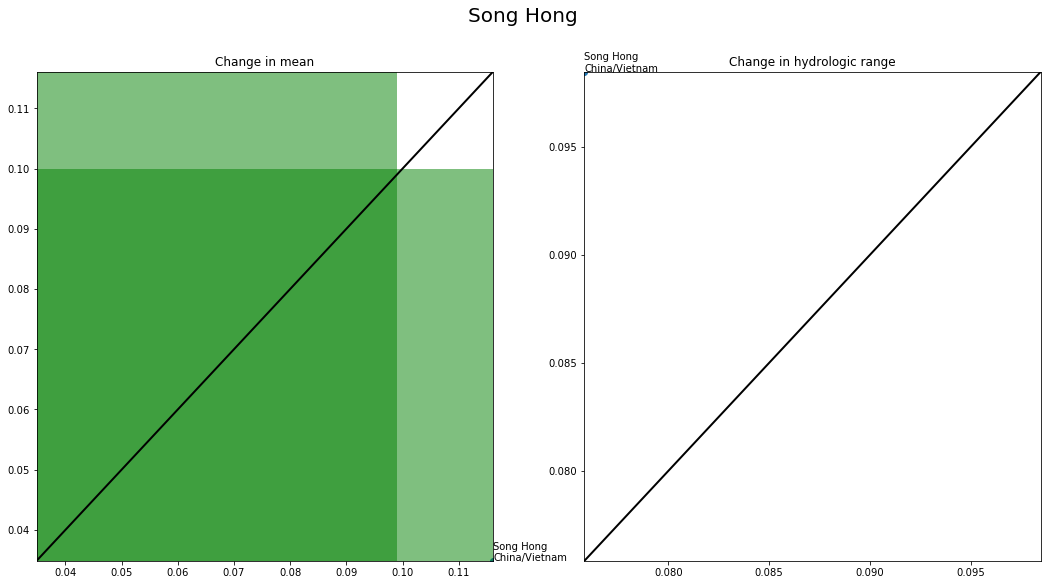

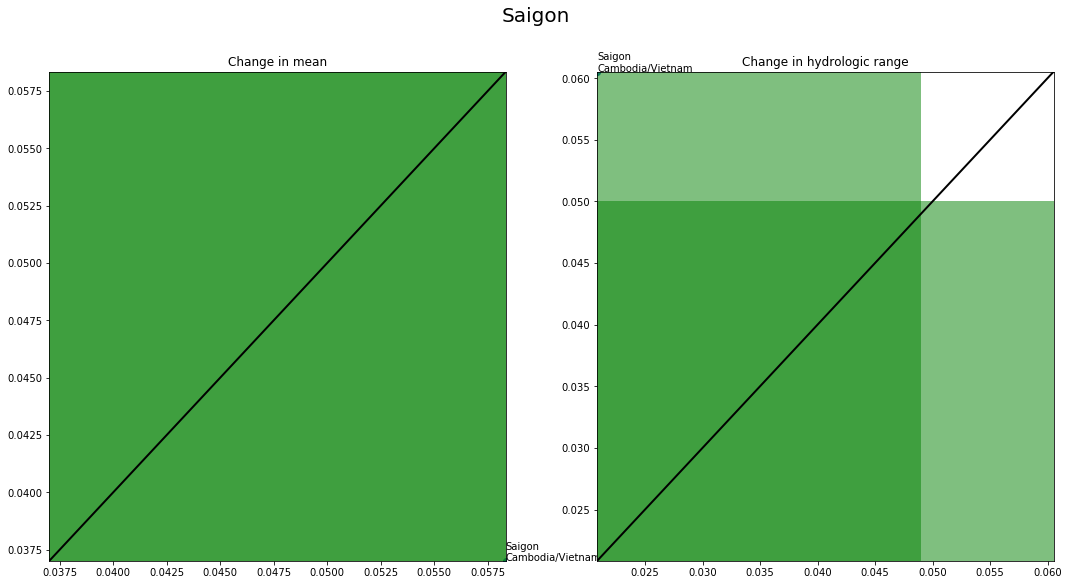

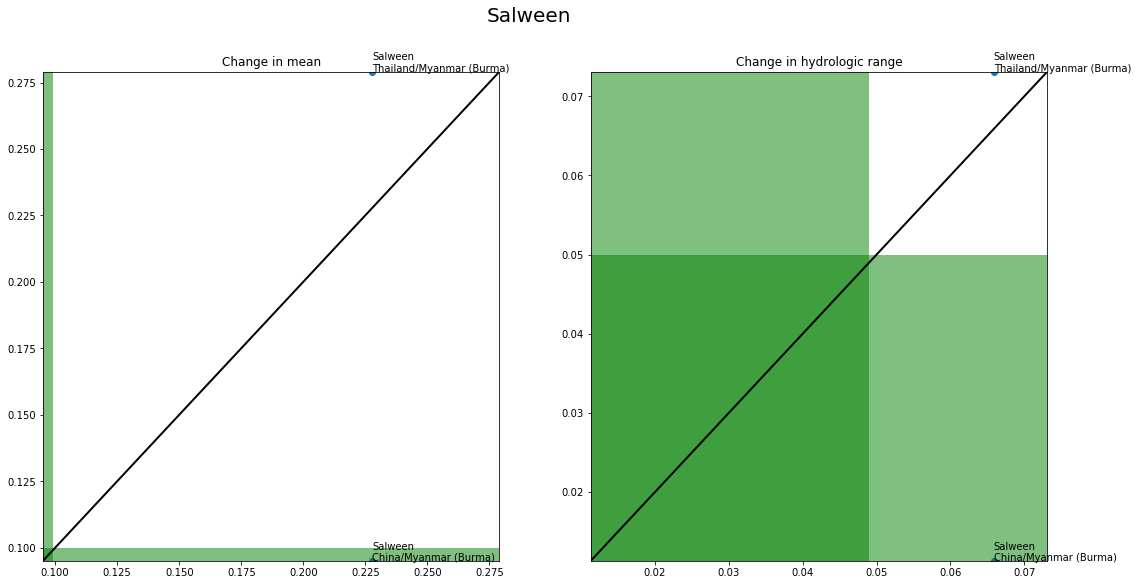

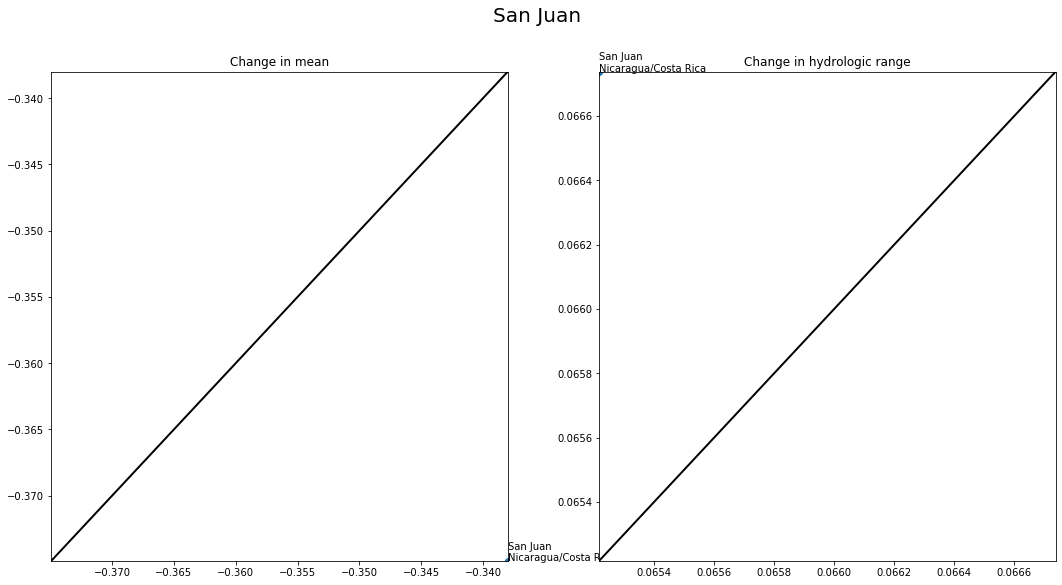

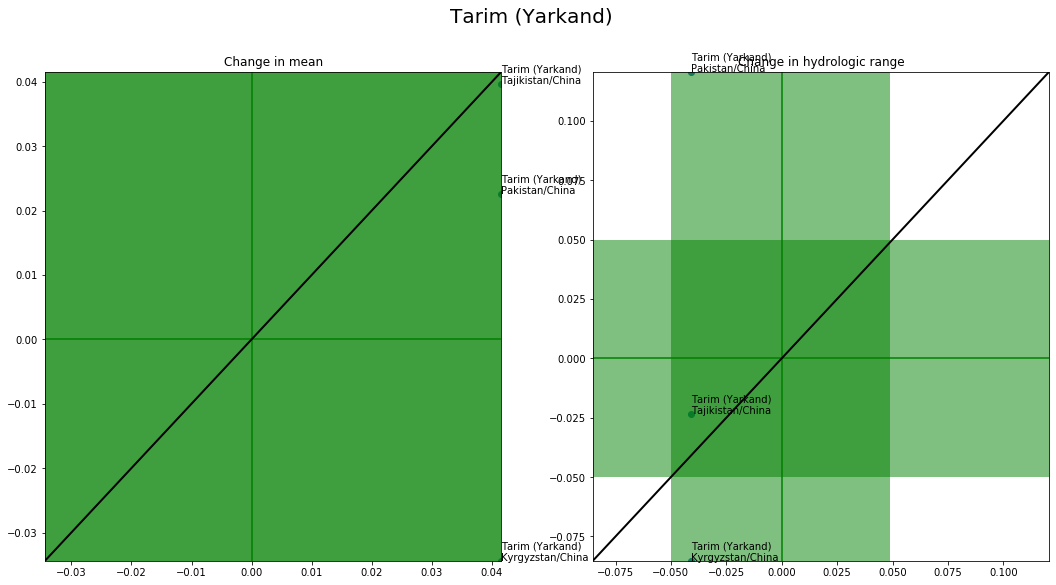

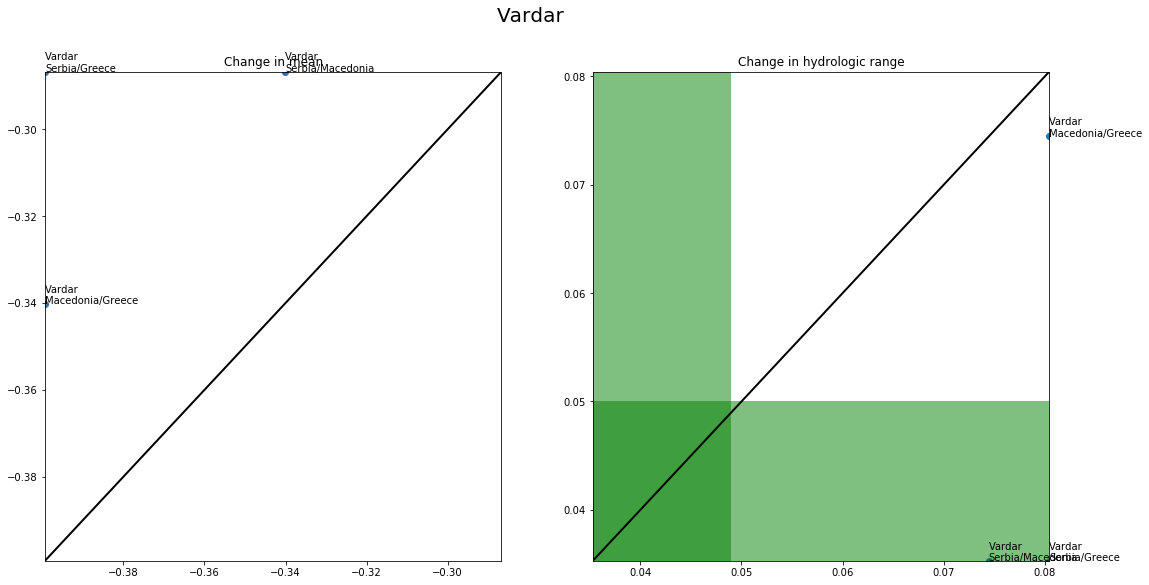

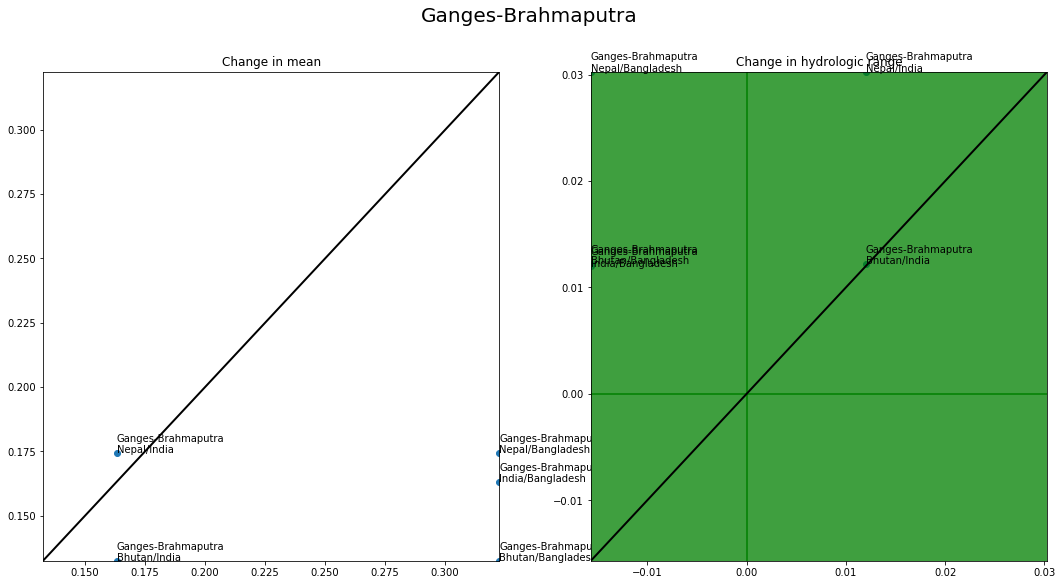

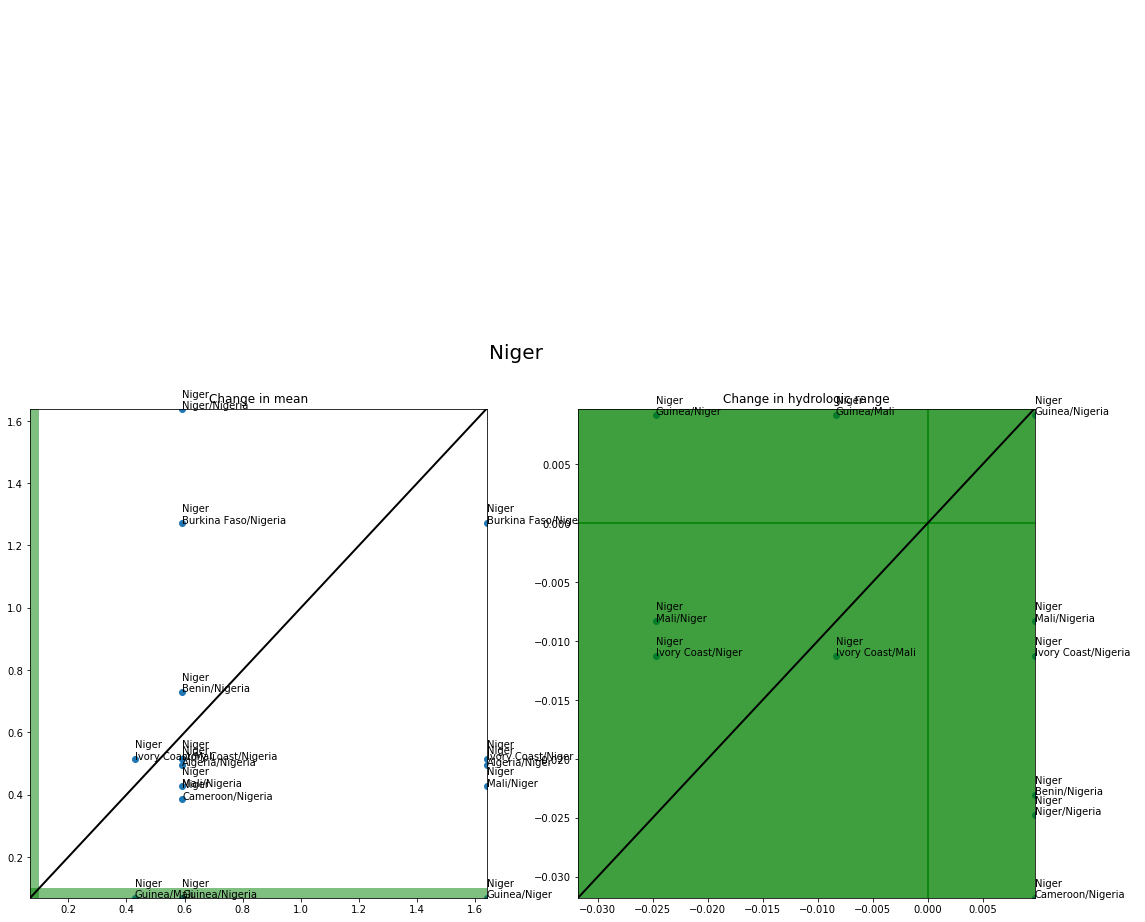

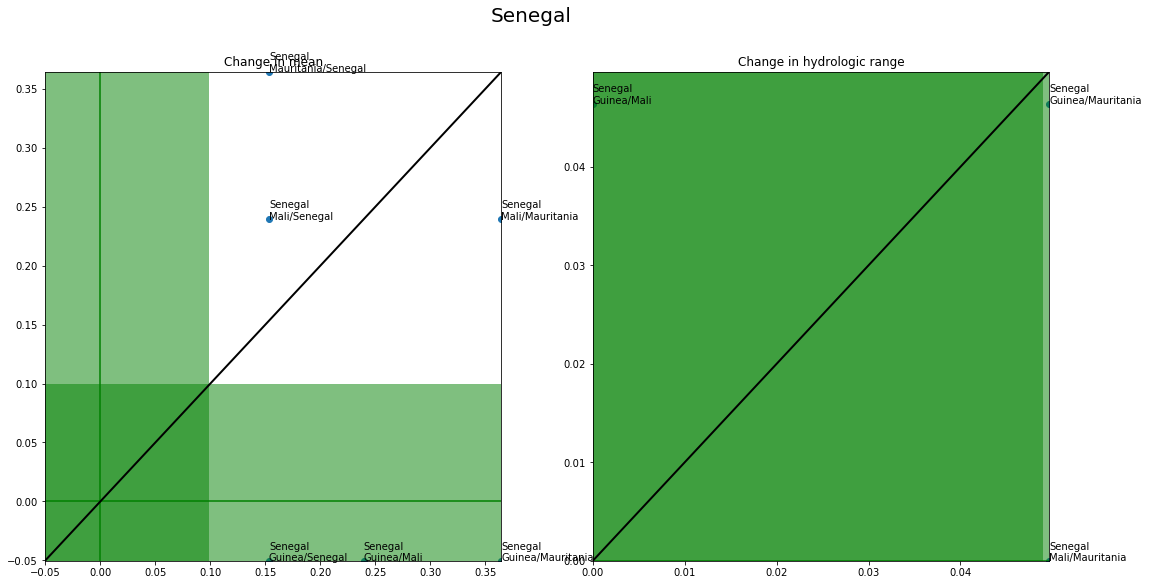

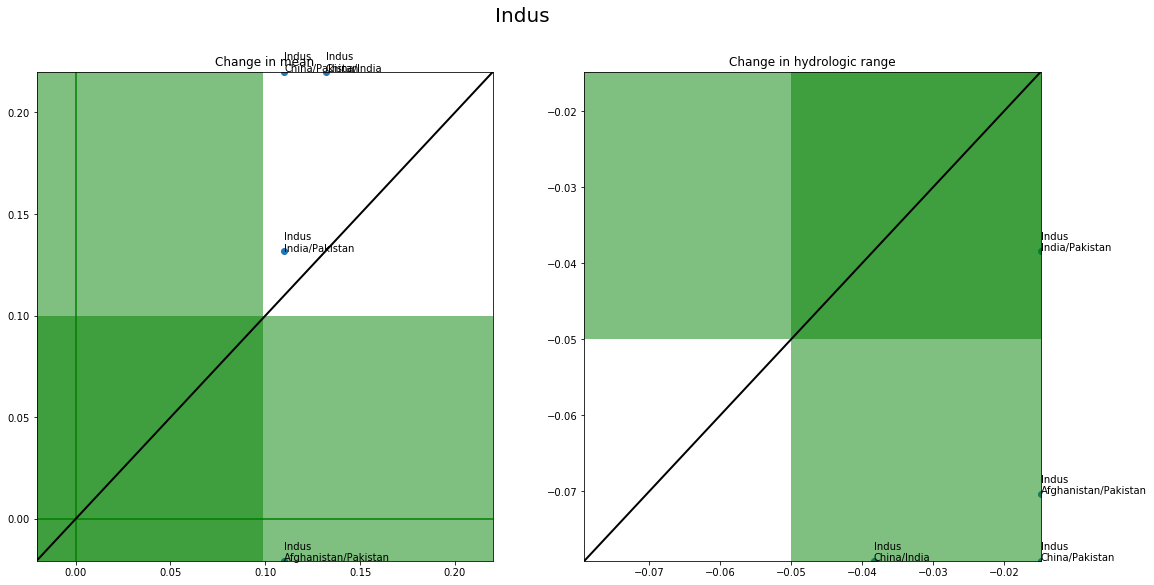

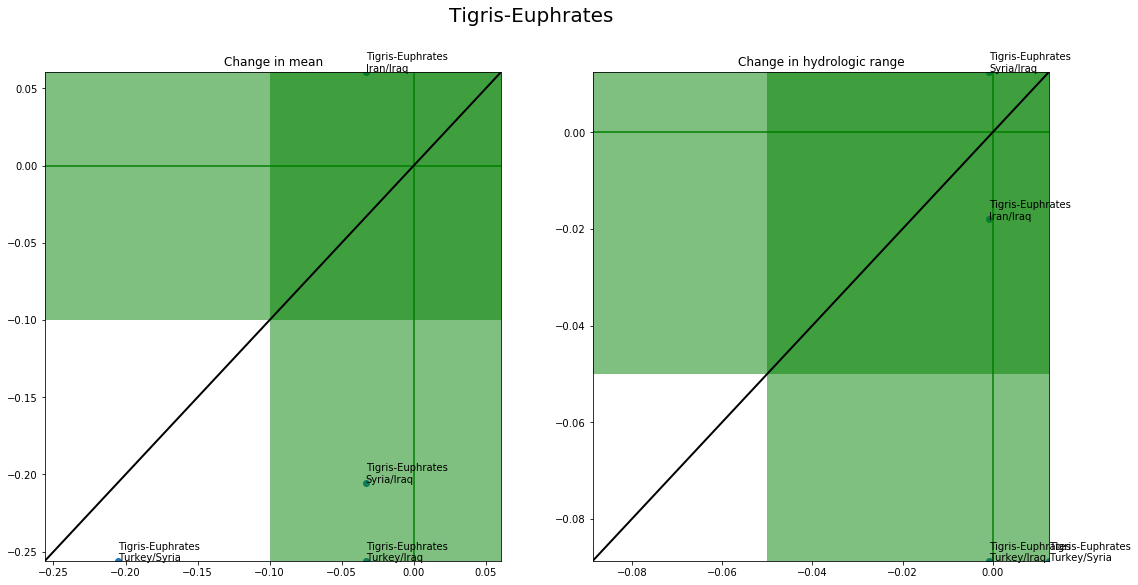

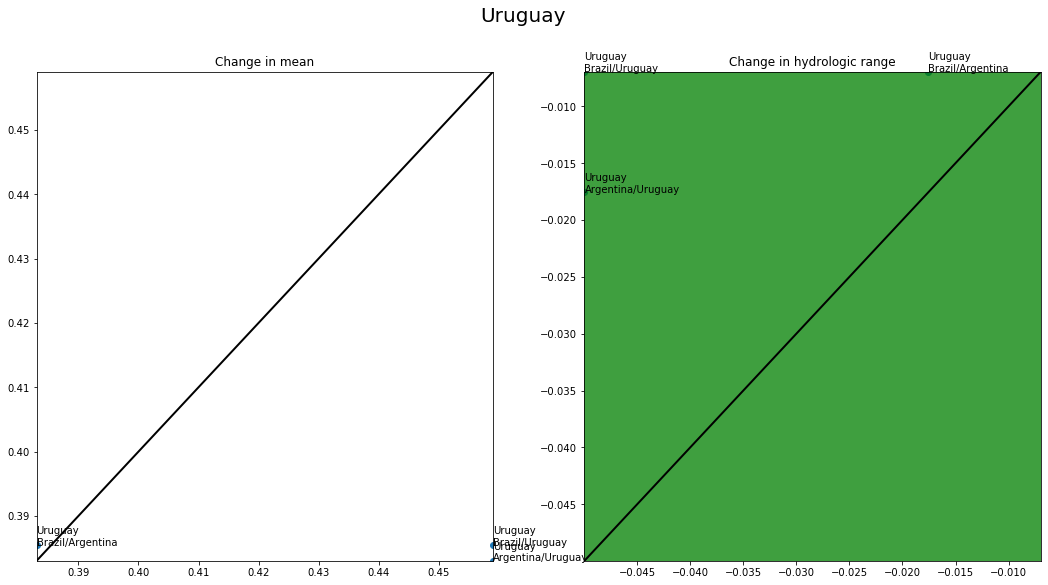

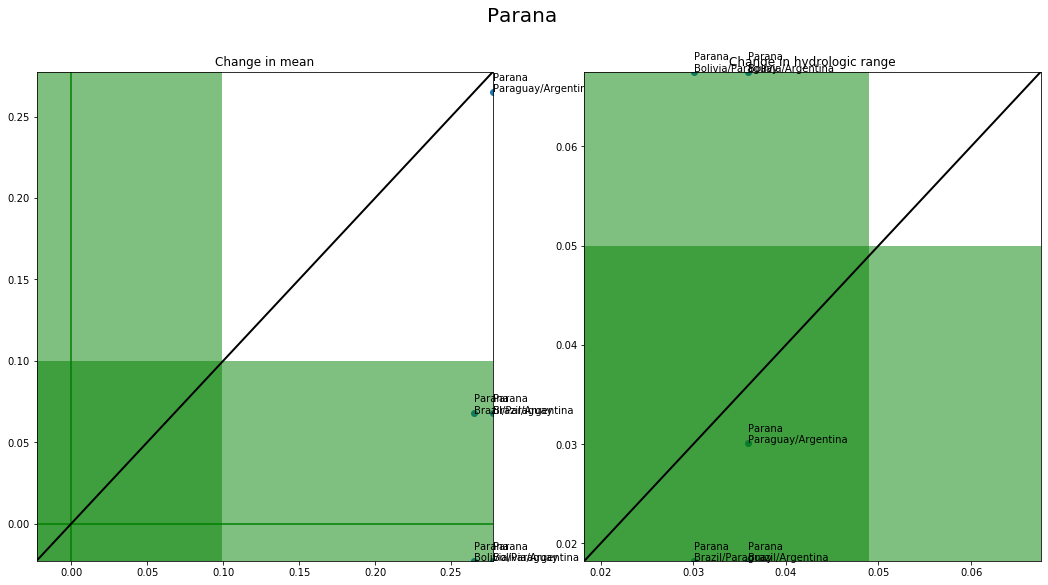

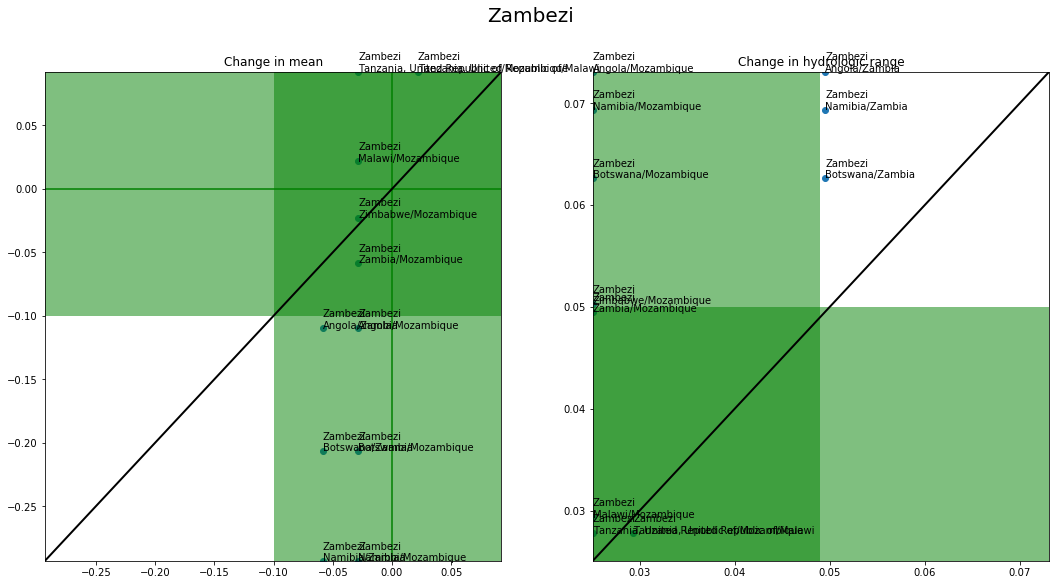

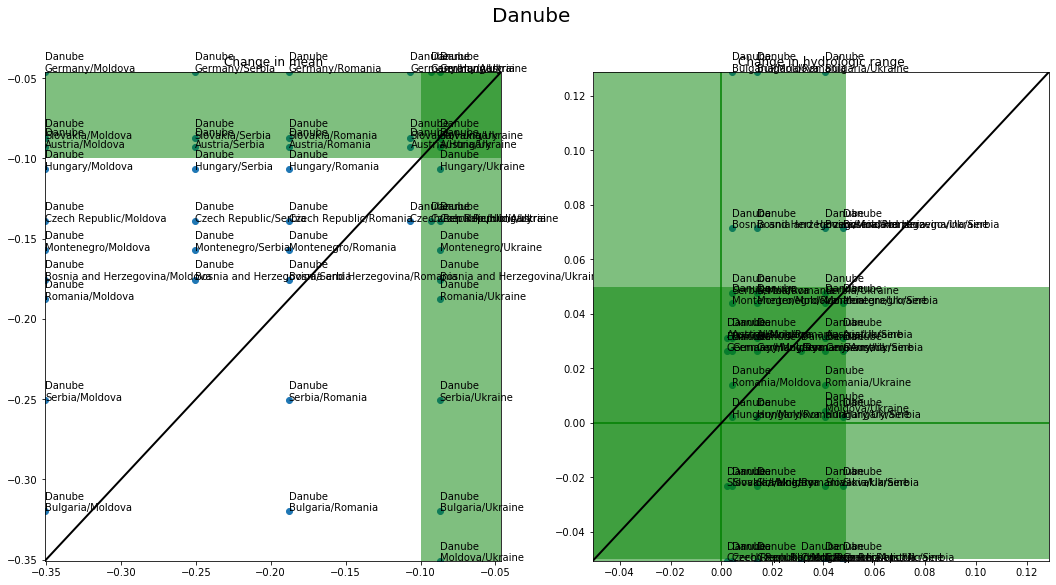

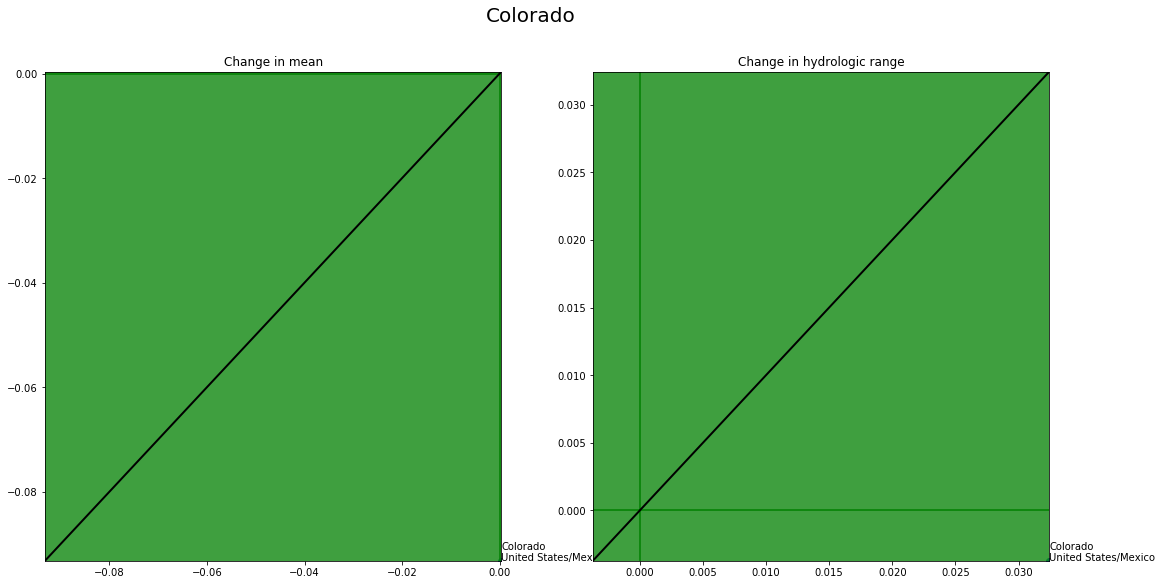

In [37]:
for river in river_basin_comparison_dict['mean'].keys():
    fig, axarr = plt.subplots(ncols=2, figsize=(18,9))
    fig.suptitle(river, fontsize=20)
    band_limits = {'mean': [-0.1, 0.1],
                  'hydrologic range': [-0.05, 0.05]}
    plot_limits = {'mean': [-1, 1.8],
                  'hydrologic range': [-0.7, 0.7]}
    for i, metric in enumerate(['mean', 'hydrologic range']):
        ax=axarr[i]
        ax.set_title('Change in {}'.format(metric))
        river_upstream_downstream_df = river_basin_comparison_dict[metric][river]['upstream/downstream df']
        ax.scatter(x=river_upstream_downstream_df['downstream'],
                    y=river_upstream_downstream_df['upstream'])
        plot_limits = {'mean': [np.min(river_upstream_downstream_df.values),
                               np.max(river_upstream_downstream_df.values)],
                  'hydrologic range': [np.min(river_upstream_downstream_df.values),
                               np.max(river_upstream_downstream_df.values)]}
        for i, txt in enumerate(river_upstream_downstream_df.index):
            ax.annotate(river+'\n'+txt, (river_upstream_downstream_df['downstream'][i], 
                              river_upstream_downstream_df['upstream'][i]))
        ax.axhline(0, color='green')
        ax.axvline(0, color='green')
        
        full_data_domain = np.arange(plot_limits[metric][0], plot_limits[metric][1]+0.01, 0.01)
        ax.fill_between(full_data_domain, band_limits[metric][0],
                           band_limits[metric][1],
                    facecolor='green', alpha=0.5)
        ax.fill_between(np.arange(band_limits[metric][0],
                           band_limits[metric][1], 0.001), 
                           plot_limits[metric][0], 
                           plot_limits[metric][1], facecolor='green', alpha=0.5)
        ax.plot([plot_limits[metric][0], plot_limits[metric][1]], 
                 [plot_limits[metric][0],plot_limits[metric][1]], 'k-', lw=2)
        ax.set_xlim(plot_limits[metric][0], plot_limits[metric][1])
        ax.set_ylim(plot_limits[metric][0], plot_limits[metric][1])
    fig.savefig('upstream_downstream_countries_{}.png'.format(river))

Mekong
Amazon
Nile
Columbia
Zaire
Essequibo
Irrawaddy
Jubba-Shebelle
Lake Turkana
Maritsa
Ob
Ogooue
Orinoco
Song Hong
Saigon
Salween
San Juan
Tarim (Yarkand)
Vardar
Ganges-Brahmaputra
Niger
Senegal
Indus
Tigris-Euphrates
Uruguay
Parana
Zambezi
Danube
Colorado
Rhine


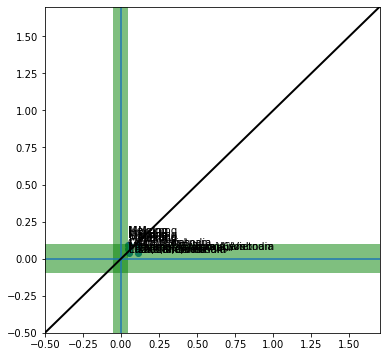

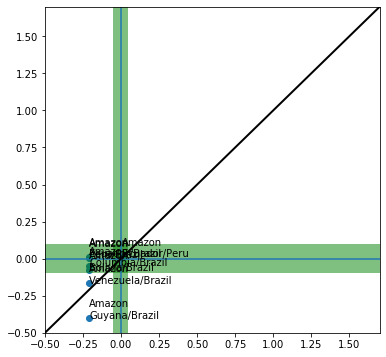

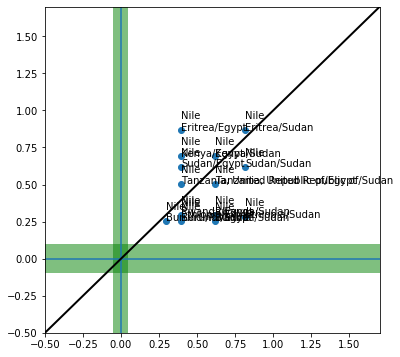

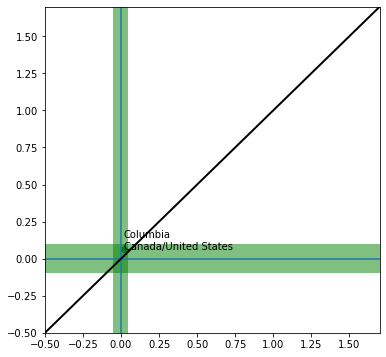

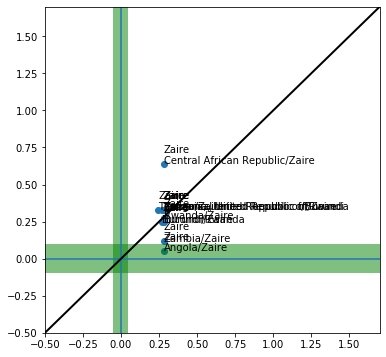

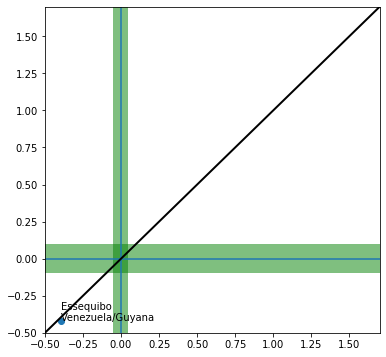

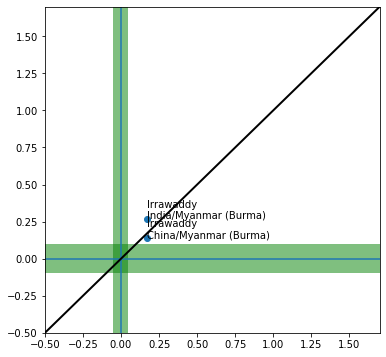

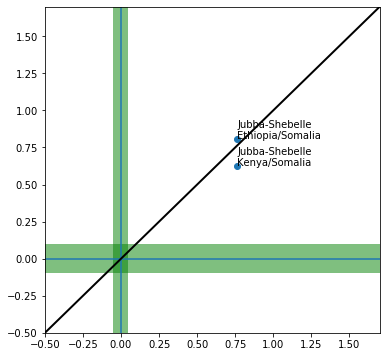

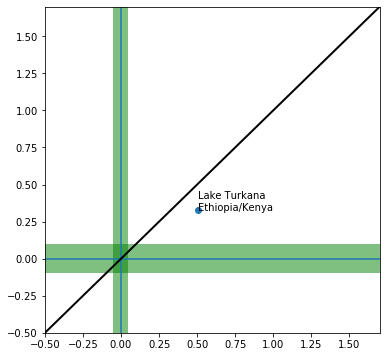

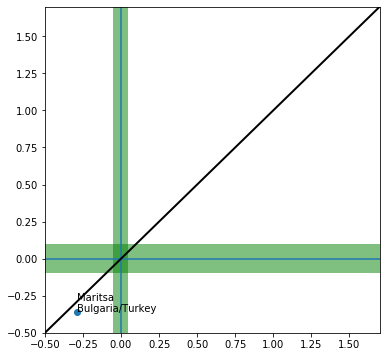

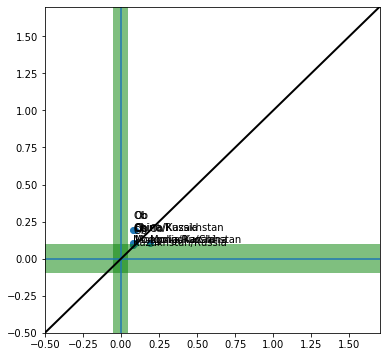

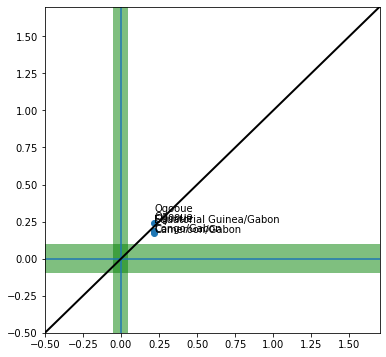

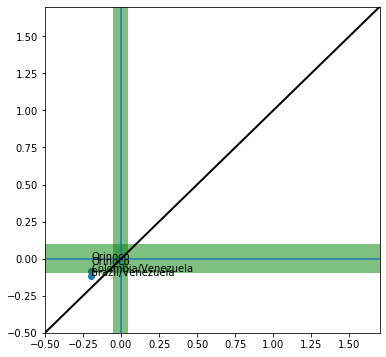

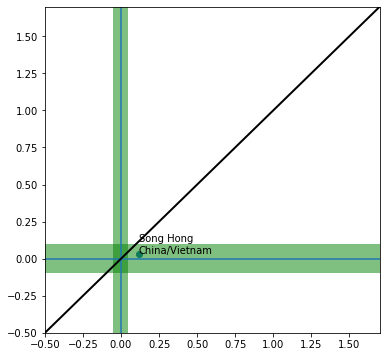

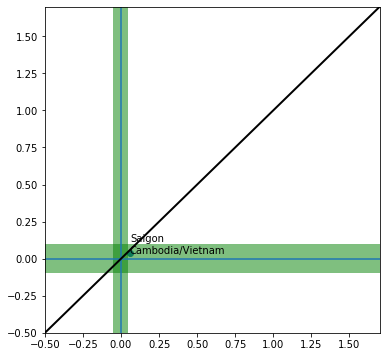

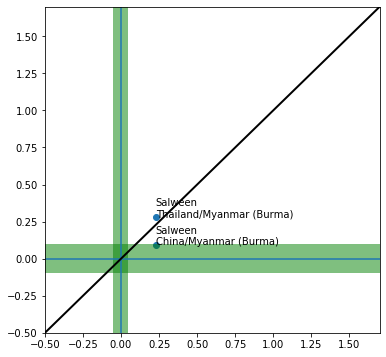

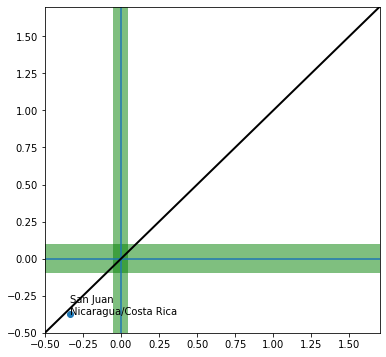

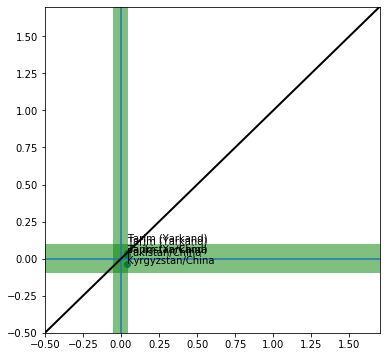

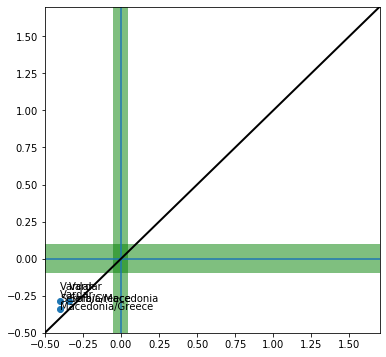

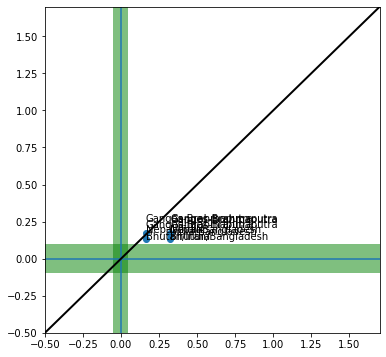

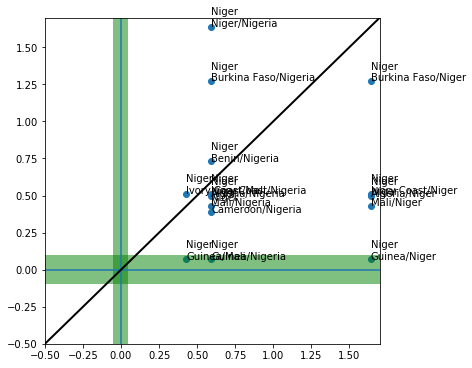

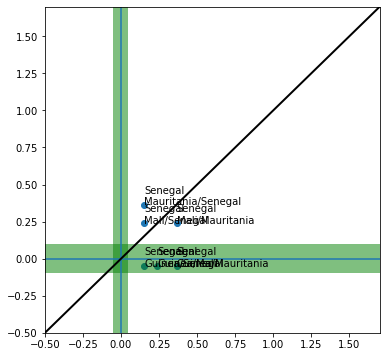

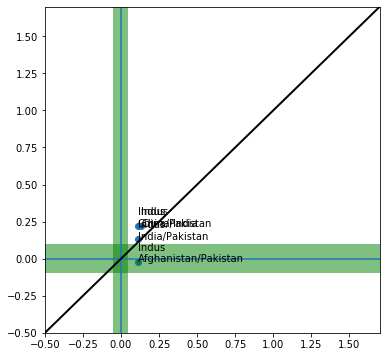

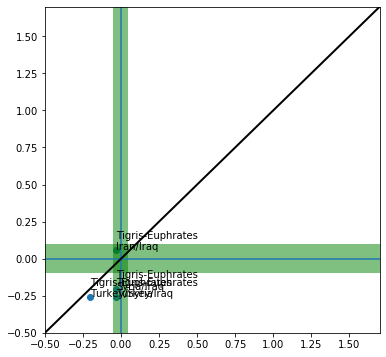

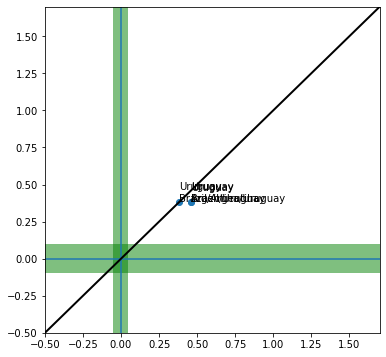

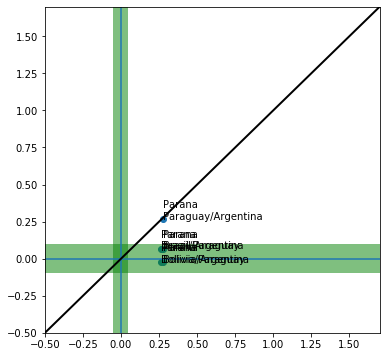

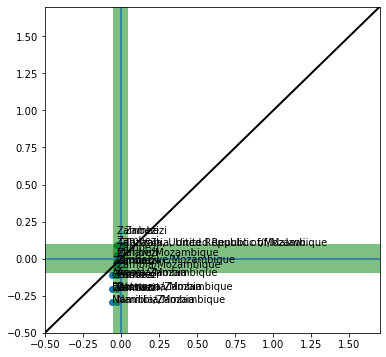

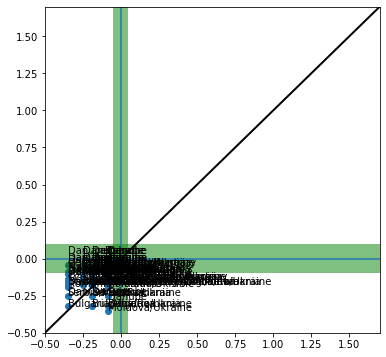

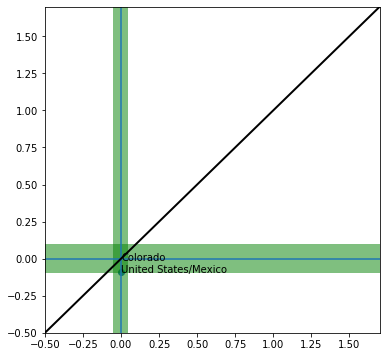

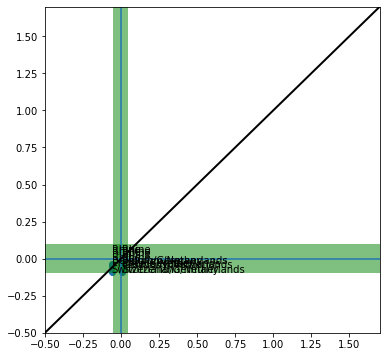

In [38]:
for river in river_basin_comparison_dict['hydrologic range'].keys():
    fig, axarr = plt.subplots(figsize=(6,6))

    print(river)
    river_upstream_downstream_df = river_basin_comparison_dict['mean'][river]['upstream/downstream df']
    axarr.scatter(x=river_upstream_downstream_df['downstream'],
                y=river_upstream_downstream_df['upstream'])
    for i, txt in enumerate(river_upstream_downstream_df.index):
        axarr.annotate(river+'\n'+txt, (river_upstream_downstream_df['downstream'][i], 
                          river_upstream_downstream_df['upstream'][i]))
    axarr.axhline(0)
    axarr.axvline(0)
    full_data_domain = np.arange(-1, 3, 0.01)
    axarr.fill_between(full_data_domain, -0.1, 0.1, 
                    facecolor='green', alpha=0.5)
    axarr.fill_between(np.arange(-0.05, 0.05, 0.001), -1,y2=3, facecolor='green', alpha=0.5)
    plt.plot([-0.6, 1.8], [-0.6,1.8], 'k-', lw=2)
    plt.xlim(-0.5, 1.7)
    plt.ylim(-0.5, 1.7)

In [39]:
def heatmap_upstream_downstream(ax, df, title):
    sns.heatmap(df, ax=ax, 
            annot=True, linewidths=3, cbar=False, #cmap='YlGnBu'
                cmap='PuBu', fmt='.2f')
    ax.set_title(title, size=24)
    ax.set_xlabel('Downstream', size=16)
    ax.set_ylabel('Upstream', size=16)

## Heat maps showing upstream/downstream interactions

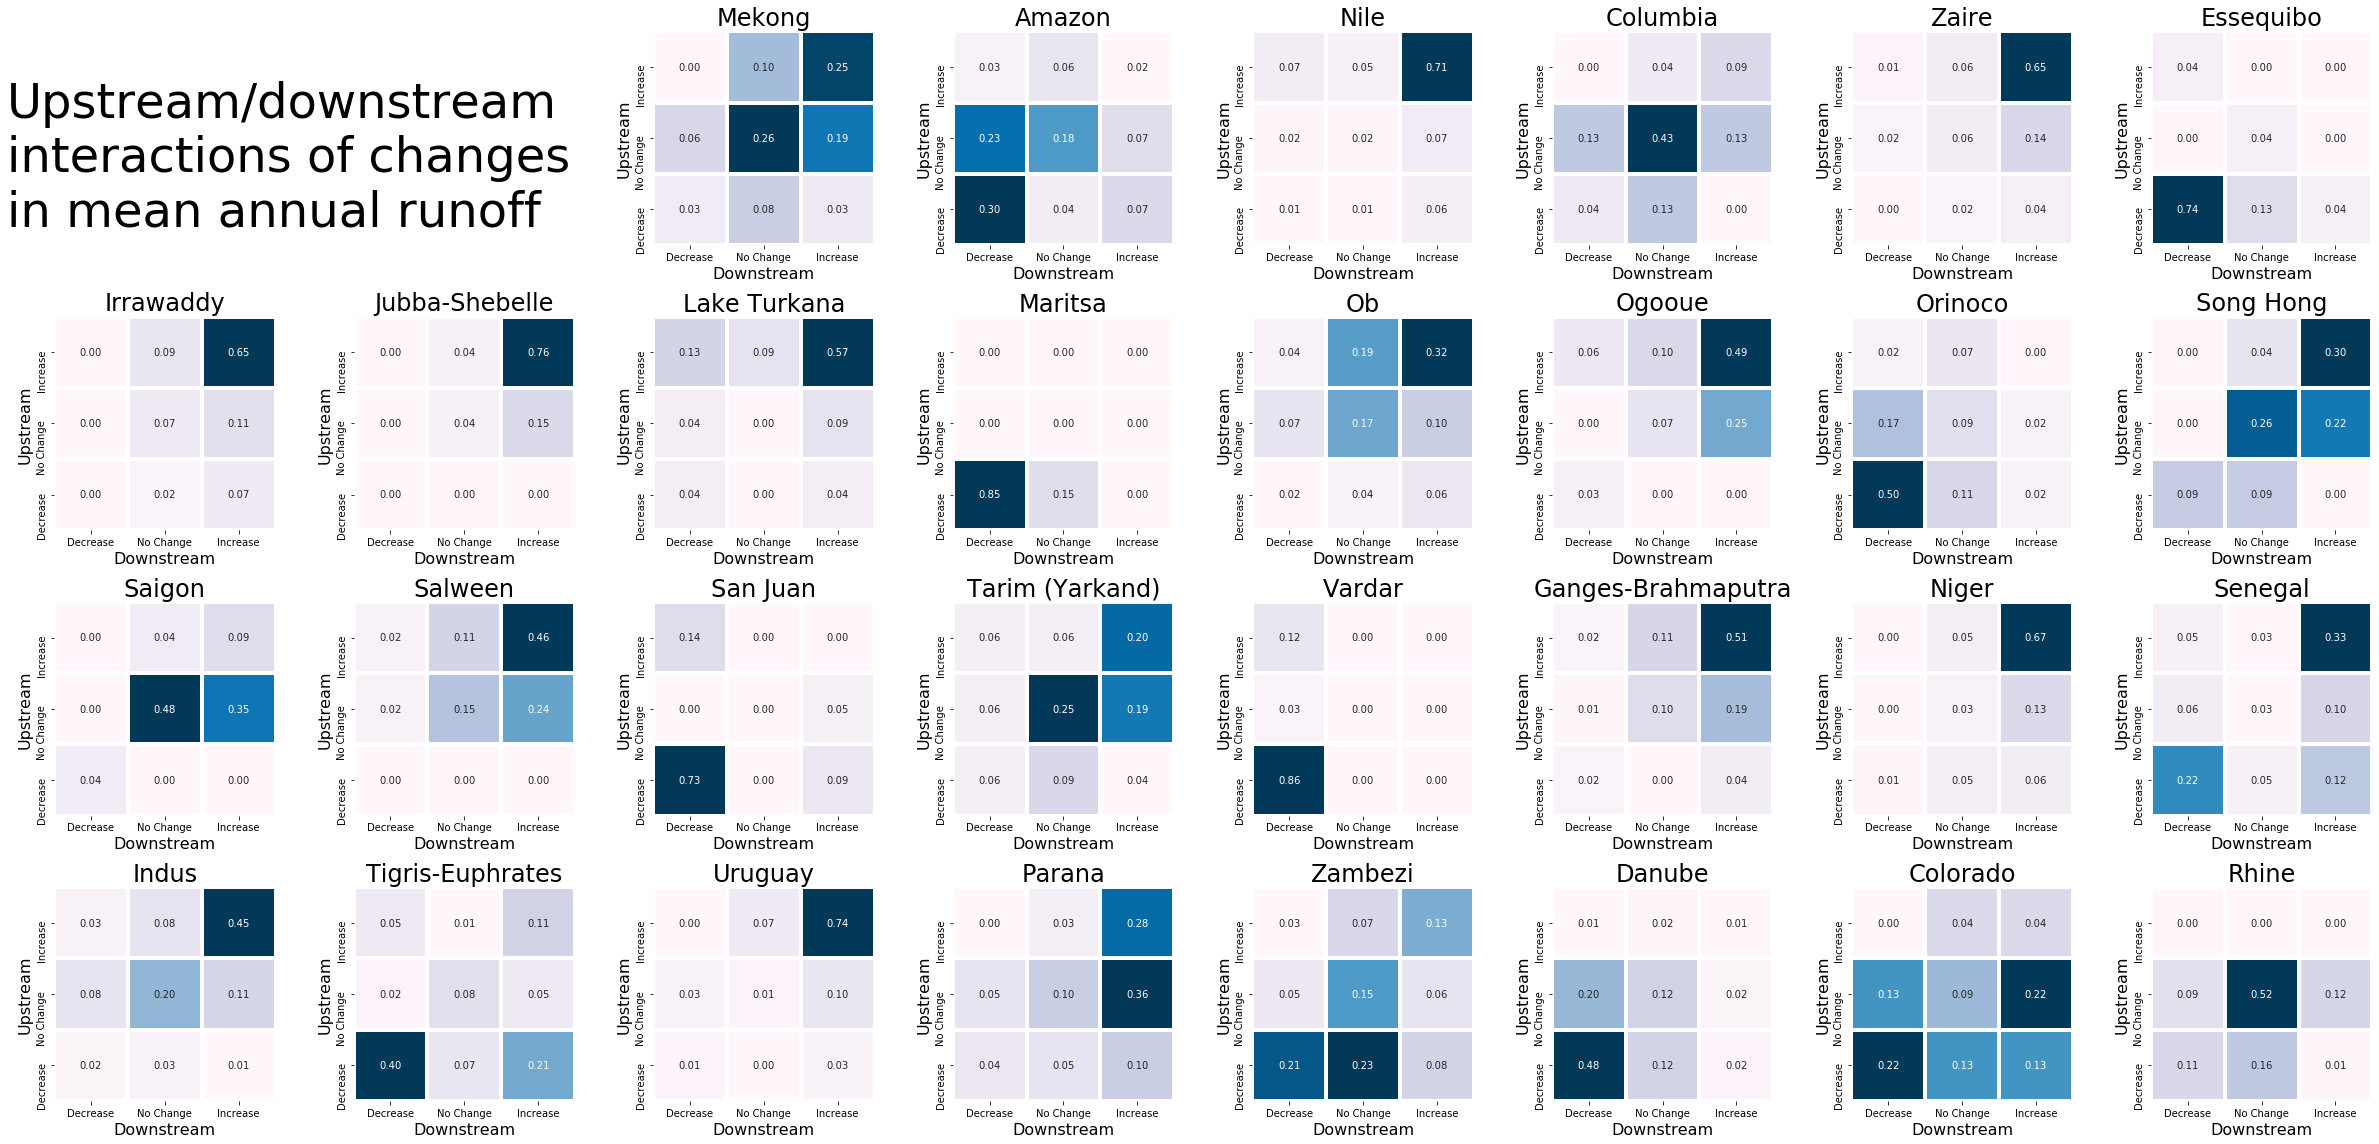

In [40]:
river_basins_toplot = list(rb.keys())

fig, axarr = plt.subplots(ncols=8, nrows=4, figsize=(33,16))

for i, river_basin in enumerate(river_basins_toplot[0:30]):
    x_location, y_location = int((i+2)/8), np.mod((i+2),8)
    interaction_df = river_basin_comparison_dict['mean'][river_basin]['Full Ensemble']
    heatmap_upstream_downstream(axarr[x_location, y_location], 
                                interaction_df/interaction_df.sum().sum(), 
                                river_basin)
fig.text(0,0.8, 'Upstream/downstream\ninteractions of changes\nin mean annual runoff',
        fontsize=48)
axarr[0,0].axis('off')
axarr[0,1].axis('off')
plt.tight_layout()
plt.savefig('../figures/upstream_downstream_comparisons_mean_tiny_upstreams_removed.svg', format='svg')

In [41]:
all_rivers = pd.DataFrame(np.zeros((3,3)), 
                         columns = ['Decrease', 'No Change', 'Increase'],
                         index = ['Increase', 'No Change', 'Decrease'])
for river in river_basin_comparison_dict['mean'].keys():
    all_rivers += river_basin_comparison_dict['mean'][river]['Full Ensemble']
all_rivers = all_rivers/all_rivers.sum().sum()

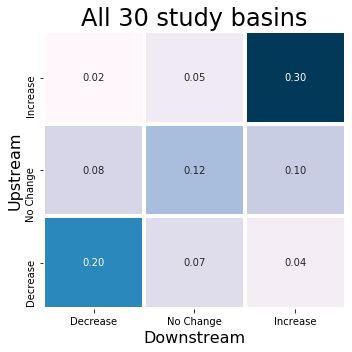

In [42]:
fig, axarr = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

heatmap_upstream_downstream(axarr, 
                        all_rivers, 
                                'All 30 study basins')
plt.tight_layout()
plt.savefig('../figures/upstream_downstream_comparisons_all_rivers.svg', format='svg')

In [43]:
# Now for hydrologic range

In [44]:
rb['Amazon'] = {'outlet_country': 'Brazil',
                'Colombia': BasinTree('Columbia', []),
                 'Ecuador': BasinTree('Ecuador', []),
                 'Bolivia': BasinTree('Bolivia', []),
             'Venezuela': BasinTree('Venezuela', []),
                 'Guyana': BasinTree('Guyana', []),
                 'French Guiana': BasinTree('French Guiana', []),}
rb['Amazon']['Peru'] = BasinTree('Peru', [rb['Amazon']['Ecuador']])
rb['Amazon']['Brazil'] = BasinTree('Brazil', [rb['Amazon'][country] for country in ['Colombia',
                                                                                   'Peru',
                                                                                   'Bolivia',
                                                                                   'Venezuela',
                                                                                   'Guyana',
                                                                                   'French Guiana']])

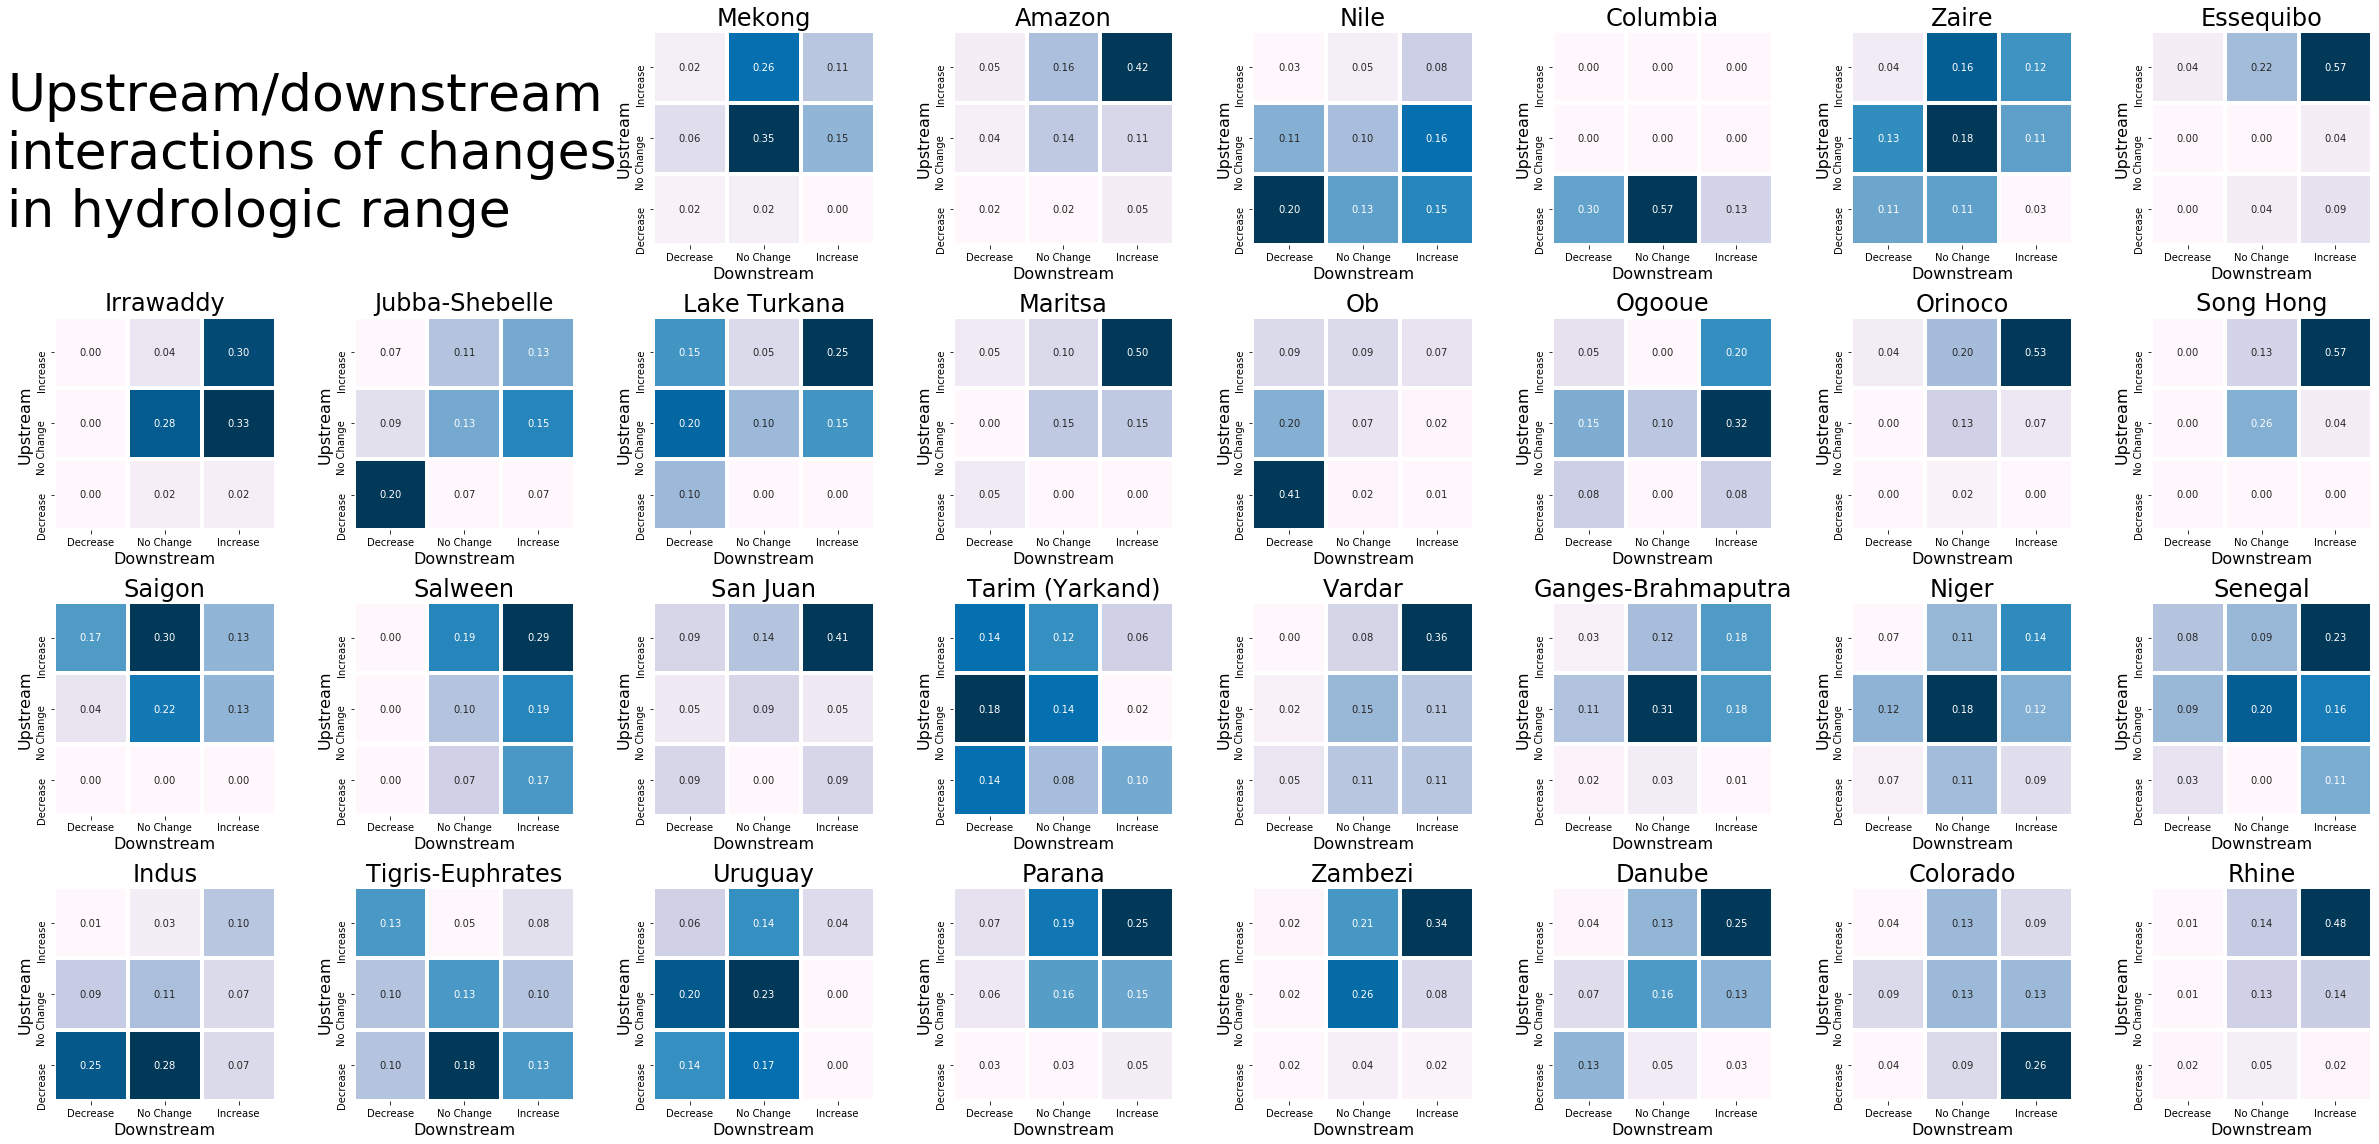

In [45]:
river_basins_toplot = list(rb.keys())
fig, axarr = plt.subplots(ncols=8, nrows=4, figsize=(33,16))

for i, river_basin in enumerate(river_basins_toplot[0:30]):
    x_location, y_location = int((i+2)/8), np.mod((i+2),8)
    interaction_df = river_basin_comparison_dict['hydrologic range'][river_basin]['Full Ensemble']
    heatmap_upstream_downstream(axarr[x_location, y_location], 
                                interaction_df/interaction_df.sum().sum(), 
                                river_basin)
fig.text(0,0.8, 'Upstream/downstream\ninteractions of changes\nin hydrologic range', fontsize=52)
axarr[0,0].axis('off')
axarr[0,1].axis('off')
plt.tight_layout()
plt.savefig('../figures/upstream_downstream_comparisons_h_range_tiny_upstreams_removed.svg', format='svg')

In [46]:
def most_frequent(List): 
    return max(set(List), key = List.count) 

In [47]:
import itertools
metrics = ['mean', 'hydrologic range']
most_common_culprit_df = pd.DataFrame(columns=['hydrologic range', 'hydrologic range culprit count', 'mean', 'mean culprit count'],
                                index=river_basin_comparison_dict['hydrologic range'].keys())
culprit_count_dictionary = {}
# Identify most common culprit hydrologic range
for river in river_basin_comparison_dict['mean'].keys():
    culprit_count_dictionary[river] = pd.DataFrame(columns=metrics)
    for metric in metrics:
        all_bad_countries = list(itertools.chain.from_iterable(river_basin_comparison_dict[metric][river]['bad countries']))
        unique_bad_countries = list(set(all_bad_countries))
        # first fill the most_common_culprit df
        most_common_culprit_df.at[river, metric] = most_frequent(all_bad_countries)
        most_common_culprit_df.at[river, metric+' culprit count'] = all_bad_countries.count(most_frequent(all_bad_countries))
        # then fill the basin-specific culprit df
        for country in unique_bad_countries:
            culprit_count_dictionary[river].at[country, metric] = all_bad_countries.count(country)

ValueError: max() arg is an empty sequence

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [49]:
for river in culprit_count_dictionary.keys():
    printmd('**{}**'.format(river))
    print(culprit_count_dictionary[river])

**Mekong**

                mean hydrologic range
Cambodia           1                6
China              4                6
Laos               2                5
Myanmar (Burma)    3               12
Thailand           4               13
Vietnam            3                6


**Amazon**

          mean hydrologic range
Peru         6               14
Columbia     4               19
Venezuela   16               14
Ecuador      7               10
Bolivia     11               15
Brazil      14               13
Guyana      16               19


**Nile**

                             mean hydrologic range
Kenya                           2                2
Tanzania, United Republic of    1                1
Sudan                           2               14
Rwanda                          3                6
Burundi                         3                2
Egypt                           3                8
Eritrea                       NaN                2
Ethiopia                      NaN                4


**Columbia**

              mean hydrologic range
Canada           4              NaN
United States    4                3


**Zaire**

                             mean hydrologic range
Congo                           3               10
Tanzania, United Republic of    1                6
Angola                          1               15
Zambia                          3                7
Rwanda                          4                5
Zaire                         NaN                6
Central African Republic      NaN                8
Burundi                       NaN                4


**Essequibo**

          mean hydrologic range
Venezuela   21               19
Guyana      18               16


**Irrawaddy**

                mean hydrologic range
China              3               11
India              1                5
Myanmar (Burma)  NaN               15


**Jubba-Shebelle**

Empty DataFrame
Columns: [mean, hydrologic range]
Index: []


In [50]:
most_common_culprit_df

hydrologic range hydrologic range culprit count       mean  \
Mekong                     Thailand                             13      China   
Amazon                     Columbia                             19  Venezuela   
Nile                          Sudan                             14     Rwanda   
Columbia              United States                              3     Canada   
Zaire                        Angola                             15     Rwanda   
Essequibo                 Venezuela                             19  Venezuela   
Irrawaddy           Myanmar (Burma)                             15      China   
Jubba-Shebelle                  NaN                            NaN        NaN   
Lake Turkana                    NaN                            NaN        NaN   
Maritsa                         NaN                            NaN        NaN   
Ob                              NaN                            NaN        NaN   
Ogooue                          NaN                            NaN        NaN   
Orinoco                         NaN                            NaN        NaN   
Song Hong                       NaN                            NaN        NaN   
Saigon                          NaN                            NaN        NaN   
Salween                         NaN                            NaN        NaN   
San Juan                        NaN                            NaN        NaN   
Tarim (Yarkand)                 NaN                            NaN        NaN   
Vardar                          NaN                            NaN        NaN   
Ganges-Brahmaputra              NaN                            NaN        NaN   
Niger                           NaN                            NaN        NaN   
Senegal                         NaN                            NaN        NaN   
Indus                           NaN                            NaN        NaN   
Tigris-Euphrates                NaN                            NaN        NaN   
Uruguay                         NaN                            NaN        NaN   
Parana                          NaN                            NaN        NaN   
Zambezi                         NaN                            NaN        NaN   
Danube                          NaN                            NaN        NaN   
Colorado                        NaN                            NaN        NaN   
Rhine                           NaN                            NaN        NaN   

                   mean culprit count  
Mekong                              4  
Amazon                             16  
Nile                                3  
Columbia                            4  
Zaire                               4  
Essequibo                          21  
Irrawaddy                           3  
Jubba-Shebelle                    NaN  
Lake Turkana                      NaN  
Maritsa                           NaN  
Ob                                NaN  
Ogooue                            NaN  
Orinoco                           NaN  
Song Hong                         NaN  
Saigon                            NaN  
Salween                           NaN  
San Juan                          NaN  
Tarim (Yarkand)                   NaN  
Vardar                            NaN  
Ganges-Brahmaputra                NaN  
Niger                             NaN  
Senegal                           NaN  
Indus                             NaN  
Tigris-Euphrates                  NaN  
Uruguay                           NaN  
Parana                            NaN  
Zambezi                           NaN  
Danube                            NaN  
Colorado                          NaN  
Rhine                             NaN

In [51]:
common_culprit_df.to_csv('most_common_culprit_excluding_tinyupstream.csv')

NameError: name 'common_culprit_df' is not defined

In [52]:
all_rivers = pd.DataFrame(np.zeros((3,3)), 
                         columns = ['Decrease', 'No Change', 'Increase'],
                         index = ['Increase', 'No Change', 'Decrease'])
for river in river_basin_comparison_dict['hydrologic range'].keys():
    all_rivers += river_basin_comparison_dict['hydrologic range'][river]['Full Ensemble']
all_rivers = all_rivers/all_rivers.sum().sum()

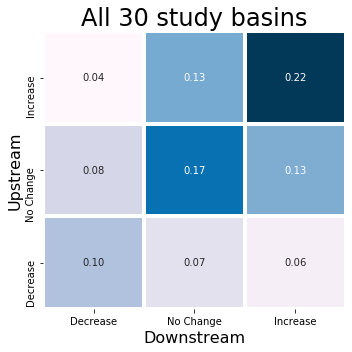

In [53]:
fig, axarr = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

heatmap_upstream_downstream(axarr, 
                        all_rivers, 
                                'All 30 study basins')
plt.tight_layout()
plt.savefig('../figures/upstream_downstream_comparisons_all_rivers_h_range.svg', format='svg')

In [49]:
risk_file = '~/other_datasets/twap_basin_risks.xlsx'
risk_data = pd.read_excel(risk_file)


rename_rivers_dict = {'Tigris-Euphrates': 'Tigris-Euphrates/Shatt al Arab',
                     'Tarim (Yarkand)': 'Tarim',
                      'Ganges-Brahmaputra': 'Ganges-Brahmaputra-Meghna',
                     'Parana': 'La Plata',
                     'Uruguay': 'La Plata',
                     'Jubba-Shebelle': 'Juba-Shibeli',
                     'Zaire': 'Congo/Zaire',
                     'Song Hong': 'Red/Song Hong'}

In [50]:
def grab_fraction_of_all_entries(df, change_of_interest):
    from_rows = df.ix[change_of_interest].sum()
    from_cols = df[change_of_interest].sum()
    duplicated_entry = df.at[change_of_interest, change_of_interest]
    total_counts = df.sum().sum()
    fraction = (from_rows + from_cols - duplicated_entry)/total_counts
    return fraction

In [51]:
def access_twap_value(indicator, risk_data, river):
    return(np.float64(risk_data[risk_data['RIVER BASIN']==river][indicator].values[0]))

In [53]:
changes_risk_df = pd.DataFrame(columns=['Annual Runoff', 'Hydrologic Range'],#, 'twap_risk', 'population'],
                              index=river_basins_toplot)
metrics_of_interest = ['11. Hydropolitical Tension', 
                       "Population [000']", 
                          '12. Enabling Environment',
                         '13. Economic Dependence on Water Resources',
                         '14. Societal Well-being']
for river in river_basins_toplot:
    # find your comparison df of interest
    h_range_df = river_basin_comparison_dict['hydrologic range'][river]['Full Ensemble']
    mean_df = river_basin_comparison_dict['mean'][river]['Full Ensemble']
    #calculate/fill increase h_range fraction
    
    changes_risk_df.at[river, 'Hydrologic Range'] = grab_fraction_of_all_entries(h_range_df, 'Increase')
    # calculate/fill decrease mean fraction
    changes_risk_df.at[river, 'Annual Runoff'] = grab_fraction_of_all_entries(mean_df, 'Decrease')
    # fill basin_risk value from twap dataset
    try:
        for indicator in metrics_of_interest:
            changes_risk_df.at[river, indicator] = access_twap_value(indicator, risk_data, river)
    except:
        for indicator in metrics_of_interest:
            changes_risk_df.at[river, indicator] = access_twap_value(indicator, risk_data, 
                                                                     rename_rivers_dict[river])

In [54]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [62]:
populations = [np.sqrt(pop) for pop in np.array(changes_risk_df["Population [000']"].values)]

# populations = np.array(changes_risk_df['population'].values)/250


# Google scholar comparisons of high-risk countries

In [67]:
google_scholar_counts = pd.DataFrame(columns=['Publication count'])
google_scholar_counts.at['Columbia', 'Publication count'] = 117000
google_scholar_counts.at['Zambezi', 'Publication count'] = 8430
google_scholar_counts.at['Saigon', 'Publication count'] = 3880
google_scholar_counts.at['Irrawaddy', 'Publication count'] = 3200
google_scholar_counts.at['Ogooue', 'Publication count'] = 422
google_scholar_counts.at['Salween', 'Publication count'] = 2070
google_scholar_counts.at['Song Hong', 'Publication count'] = 805
google_scholar_counts.at['Lake Turkana', 'Publication count'] = 2190
google_scholar_counts.at['Tarim (Yarkand)', 'Publication count'] = 310
google_scholar_counts.at['Amazon', 'Publication count'] = 55700
google_scholar_counts.at['Orinoco', 'Publication count'] = 7370
google_scholar_counts.at['Essequibo', 'Publication count'] = 406
google_scholar_counts.at['Maritsa', 'Publication count'] = 1110
google_scholar_counts.at['San Juan', 'Publication count'] = 1700
google_scholar_counts.at['Vardar', 'Publication count'] = 879

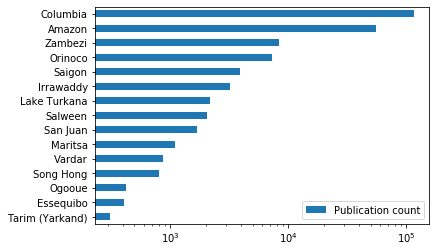

In [68]:
google_scholar_counts.sort_values(by='Publication count').plot.barh()
plt.xscale('log')

In [58]:
print('hello')

hello


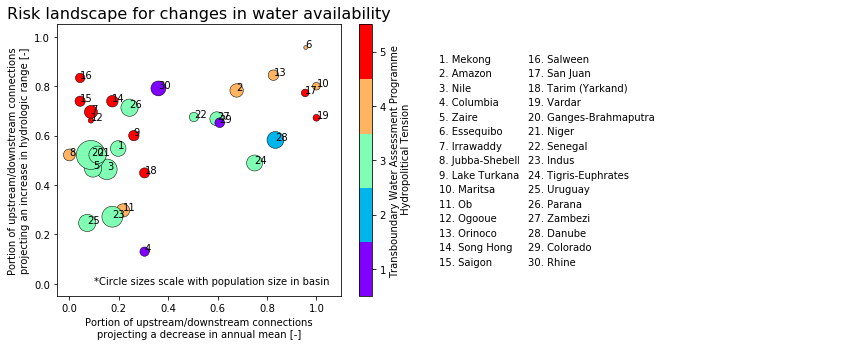

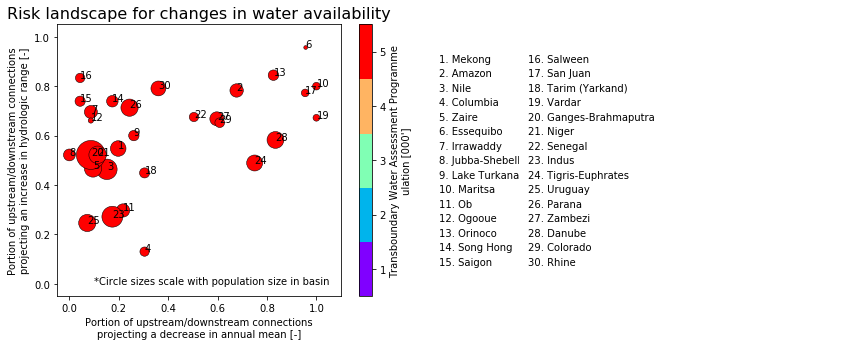

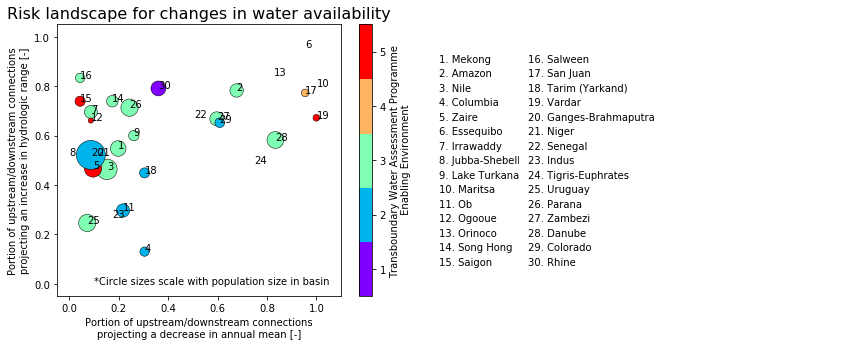

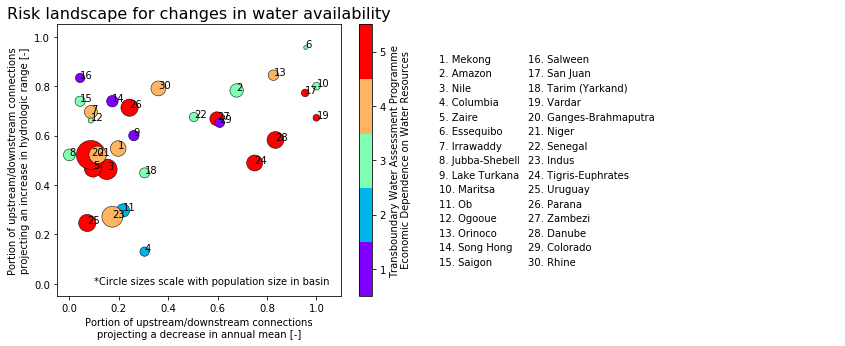

In [ ]:
for metric in metrics_of_interest:
    fig, axarr = plt.subplots(ncols=2, figsize=(14,5))

    scatter = axarr[0].scatter(x=changes_risk_df['Annual Runoff'].values,
                 y=changes_risk_df['Hydrologic Range'].values,
                 c=changes_risk_df[metric].values,
                 s=np.asarray(populations).astype(np.float64),
#                 s=np.sqrt(changes_risk_df["Population [000']"].values),
#                     s=changes_risk_df['13. Economic Dependence on Water Resources'].values*50,
                            lw=0.5, edgecolors='k',
                    cmap=plt.cm.get_cmap('rainbow', 5),
                           vmin = .5, vmax = 5.5)
    for i, river in enumerate(river_basins_toplot):
            x_location = changes_risk_df.at[river, 'Annual Runoff']#+0.04
            y_location = changes_risk_df.at[river, 'Hydrologic Range']#+0.02     
            axarr[0].annotate(i+1, (x_location, y_location))

    cax = plt.colorbar(scatter, ticks=[1,2,3,4,5], ax=axarr[0]) # , pad=-0.5
    cax.set_label('Transboundary Water Assessment Programme\n{}'.format(metric[3:]))
    axarr[0].set_xlabel('Portion of upstream/downstream connections\nprojecting a decrease in annual mean [-]')
    axarr[0].set_ylabel('Portion of upstream/downstream connections\nprojecting an increase in hydrologic range [-]')
    axarr[0].set_title('Risk landscape for changes in water availability', fontsize=16)
    axarr[0].set_ylim(-0.05,1.05)
    axarr[0].set_xlim(-0.05,1.1)
    axarr[1].axis('tight')
    axarr[1].axis('off')
    axarr[0].annotate('*Circle sizes scale with population size in basin', (0.1, 0), fontsize=10)
    table_text = []
    for i, river in enumerate(river_basins_toplot):
            table_text.append('{}. {}'.format(i+1, river))
    table_text = np.expand_dims(np.array(table_text), 1)
    table_text = table_text.reshape((2, 15)).transpose()
    # plt.subplots_adjust(left=0.2)
    the_table = plt.table(cellText=table_text,  loc='left',
                         bbox=[-0.15, 0.1, 0.5, 0.8], cellLoc='left')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    for key, cell in the_table.get_celld().items():
        cell.set_linewidth(0)
    the_table.scale(3, 3)

    plt.savefig('../figures/risk_landscape_hydropolitical_tension_excluding_tiny_metric{}.png'.format(metric), dpi=200)
